In [1]:
import tensorflow as tf
import zipfile
import io
import os
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", message="Allocation of .* exceeds 10% of free system memory")


2023-06-28 01:04:47.567938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

# Importing training Dataset

In [3]:
lr_files = os.listdir('DIV2K_train_LR_bicubicX4')
lr_files.sort(key=lambda x: int(re.findall('\d+', x)[0]))

lr_images = []
for img_file in lr_files:
    img_path = os.path.join('DIV2K_train_LR_bicubicX4', img_file)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [64, 64])
    img = img / 127.5 - 1.0
    lr_images.append(img)


In [4]:
hr_files = os.listdir('DIV2K_train_HR')
hr_files.sort(key=lambda x: int(re.findall('\d+', x)[0]))

hr_images = []
for img_file in hr_files:
    img_path = os.path.join('DIV2K_train_HR', img_file)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 127.5 - 1.0
    hr_images.append(img)


In [5]:
len(lr_images)

800

In [6]:
lr_files

['0001x4.png',
 '0002x4.png',
 '0003x4.png',
 '0004x4.png',
 '0005x4.png',
 '0006x4.png',
 '0007x4.png',
 '0008x4.png',
 '0009x4.png',
 '0010x4.png',
 '0011x4.png',
 '0012x4.png',
 '0013x4.png',
 '0014x4.png',
 '0015x4.png',
 '0016x4.png',
 '0017x4.png',
 '0018x4.png',
 '0019x4.png',
 '0020x4.png',
 '0021x4.png',
 '0022x4.png',
 '0023x4.png',
 '0024x4.png',
 '0025x4.png',
 '0026x4.png',
 '0027x4.png',
 '0028x4.png',
 '0029x4.png',
 '0030x4.png',
 '0031x4.png',
 '0032x4.png',
 '0033x4.png',
 '0034x4.png',
 '0035x4.png',
 '0036x4.png',
 '0037x4.png',
 '0038x4.png',
 '0039x4.png',
 '0040x4.png',
 '0041x4.png',
 '0042x4.png',
 '0043x4.png',
 '0044x4.png',
 '0045x4.png',
 '0046x4.png',
 '0047x4.png',
 '0048x4.png',
 '0049x4.png',
 '0050x4.png',
 '0051x4.png',
 '0052x4.png',
 '0053x4.png',
 '0054x4.png',
 '0055x4.png',
 '0056x4.png',
 '0057x4.png',
 '0058x4.png',
 '0059x4.png',
 '0060x4.png',
 '0061x4.png',
 '0062x4.png',
 '0063x4.png',
 '0064x4.png',
 '0065x4.png',
 '0066x4.png',
 '0067x4.p

In [7]:
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

In [8]:
hr_images.shape, lr_images.shape

((800, 256, 256, 3), (800, 64, 64, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


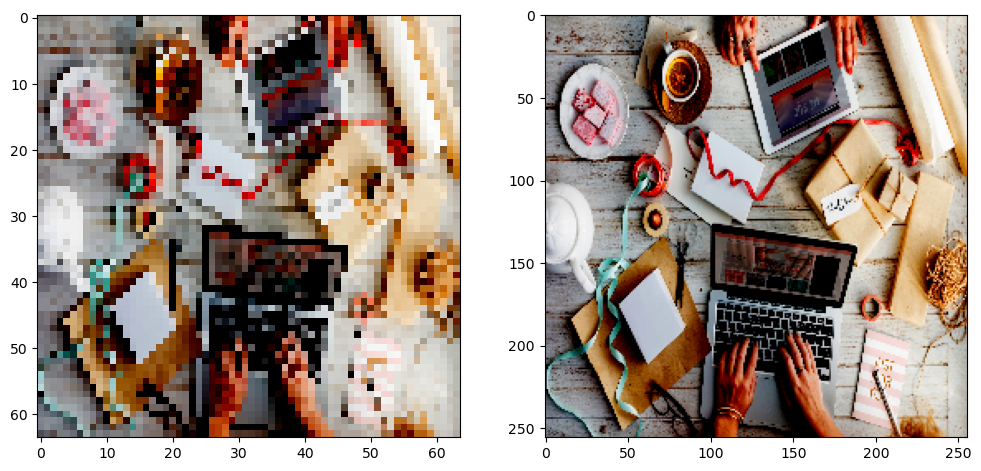

In [9]:
import random
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (64, 64, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (256, 256, 3)))
plt.show()

In [10]:
lr_train = lr_images
hr_train = hr_images


In [11]:
buffer_size = 1000  
batch_size = 32

lr_train_dataset = tf.data.Dataset.from_tensor_slices(lr_train)
hr_train_dataset = tf.data.Dataset.from_tensor_slices(hr_train)

train_dataset = tf.data.Dataset.zip((lr_train_dataset, hr_train_dataset)).shuffle(buffer_size).batch(batch_size)


# Validation dataset

In [12]:
lr_files = os.listdir('DIV2K_valid_LR_bicubicX4')
lr_files.sort(key=lambda x: int(re.findall('\d+', x)[0]))

lr_images = []
for img_file in lr_files:
    img_path = os.path.join('DIV2K_valid_LR_bicubicX4/', img_file)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [64, 64])
    img = img / 127.5 - 1.0
    lr_images.append(img)
    

In [13]:
hr_files = os.listdir('DIV2K_valid_HR')
hr_files.sort(key=lambda x: int(re.findall('\d+', x)[0]))

hr_images = []
for img_file in hr_files:
    img_path = os.path.join('DIV2K_valid_HR/', img_file)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 127.5 - 1.0
    hr_images.append(img)


In [14]:
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


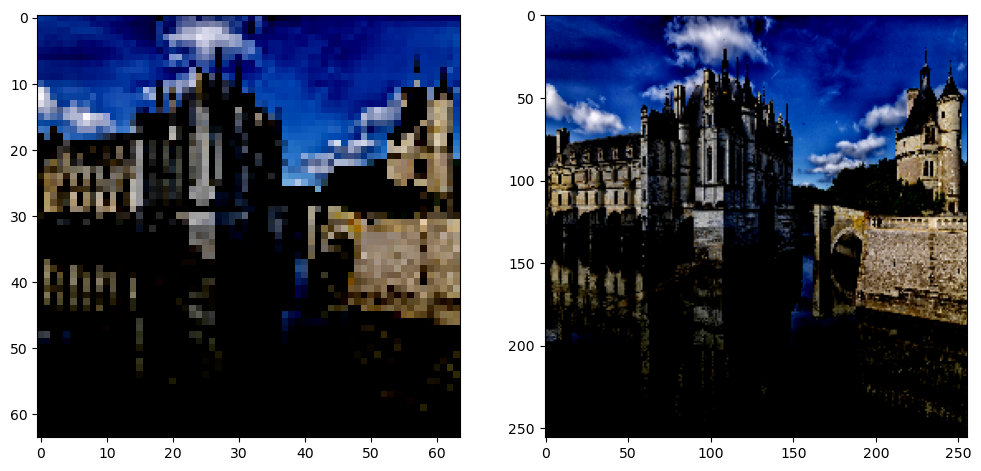

In [15]:
import random
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (64, 64, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (256, 256, 3)))
plt.show()

In [16]:
lr_val= lr_images
hr_val = hr_images


In [17]:
buffer_size = 1000  
batch_size = 32

lr_val_dataset = tf.data.Dataset.from_tensor_slices(lr_val)
hr_val_dataset = tf.data.Dataset.from_tensor_slices(hr_val)

val_dataset = tf.data.Dataset.zip((lr_val_dataset, hr_val_dataset)).shuffle(buffer_size).batch(batch_size)


In [18]:
lr_val.shape, hr_val.shape, lr_train.shape, hr_train.shape

((100, 64, 64, 3), (100, 256, 256, 3), (800, 64, 64, 3), (800, 256, 256, 3))

In [19]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [20]:
hr_shape = (hr_val.shape[1], hr_val.shape[2], hr_val.shape[3])
lr_shape = (lr_val.shape[1], lr_val.shape[2], lr_val.shape[3])

lr_ip_val = Input(shape=lr_shape)
hr_ip_val = Input(shape=hr_shape)

# Training Model

In [21]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [22]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [23]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [24]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [25]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [26]:
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [27]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [28]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 64, 64, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

                                                                                                  
 conv2d_11 (Conv2D)             (None, 64, 64, 64)   36928       ['add_4[0][0]']                  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 64, 64, 64)  256         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 p_re_lu_6 (PReLU)              (None, 64, 64, 64)   64          ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 64, 64, 64)   36928       ['p_re_lu_6[0][0]']              
                                                                                                  
 batch_nor

 conv2d_22 (Conv2D)             (None, 64, 64, 64)   36928       ['p_re_lu_11[0][0]']             
                                                                                                  
 batch_normalization_21 (BatchN  (None, 64, 64, 64)  256         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_10 (Add)                   (None, 64, 64, 64)   0           ['add_9[0][0]',                  
                                                                  'batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 64, 64, 64)   36928       ['add_10[0][0]']                 
                                                                                                  
 batch_nor

 conv2d_33 (Conv2D)             (None, 64, 64, 64)   36928       ['add_15[0][0]']                 
                                                                                                  
 batch_normalization_32 (BatchN  (None, 64, 64, 64)  256         ['conv2d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_16 (Add)                   (None, 64, 64, 64)   0           ['batch_normalization_32[0][0]', 
                                                                  'p_re_lu[0][0]']                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 64, 64, 256)  147712      ['add_16[0][0]']                 
                                                                                                  
 up_sampli

In [29]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_33 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                           

In [30]:
vgg = build_vgg(hr_shape)
print(vgg.summary())
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [31]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [32]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 256, 256, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            138912577   ['model[0][0]']            

In [33]:
batch_size = 64  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [34]:
gen_loss=[]
disc_loss=[]

epochs = 150
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    gen_loss.append(g_loss)
    disc_loss.append(d_loss)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_en_"+ str(e+1) +".h5")

  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:25, 155.08s/it]

2/2 [==============================] - 2s 834ms/step


 17%|█████████████▊                                                                     | 2/12 [05:03<25:12, 151.20s/it]

2/2 [==============================] - 2s 836ms/step


 25%|████████████████████▊                                                              | 3/12 [07:36<22:47, 151.94s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:06<20:11, 151.38s/it]

2/2 [==============================] - 2s 834ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:33<17:28, 149.73s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:03<14:58, 149.79s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:33<12:28, 149.79s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:59<09:54, 148.71s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:27<07:24, 148.27s/it]

2/2 [==============================] - 2s 835ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [24:56<04:57, 148.58s/it]

2/2 [==============================] - 2s 833ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:21<02:27, 147.46s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [29:49<00:00, 149.08s/it]


epoch: 1 g_loss: 350.94540278116864 d_loss: [52.60140074  0.57617188]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:25<26:44, 145.83s/it]

2/2 [==============================] - 2s 836ms/step


 17%|█████████████▊                                                                     | 2/12 [04:53<24:30, 147.00s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:23<22:12, 148.08s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:49<19:40, 147.56s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:17<17:14, 147.79s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:45<14:47, 147.86s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:15<12:21, 148.30s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:40<09:49, 147.48s/it]

2/2 [==============================] - 2s 835ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:10<07:24, 148.29s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [24:39<04:56, 148.34s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:09<02:28, 148.77s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [29:42<00:00, 148.54s/it]


epoch: 2 g_loss: 200.4774284362793 d_loss: [1.4770108  0.87825521]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 833ms/step


  8%|██████▉                                                                            | 1/12 [02:30<27:34, 150.43s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:00<25:04, 150.49s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:31<22:36, 150.70s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:02<20:06, 150.79s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:32<17:32, 150.36s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:03<15:04, 150.69s/it]

2/2 [==============================] - 2s 831ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:31<12:27, 149.57s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:58<09:55, 148.82s/it]

2/2 [==============================] - 2s 835ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:29<07:28, 149.55s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:00<05:00, 150.18s/it]

2/2 [==============================] - 2s 835ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:30<02:29, 149.84s/it]

2/2 [==============================] - 2s 832ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:03<00:00, 150.31s/it]


epoch: 3 g_loss: 169.93962987263998 d_loss: [0.17714406 0.98372396]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 832ms/step


  8%|██████▉                                                                            | 1/12 [02:27<27:02, 147.51s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [04:58<24:53, 149.35s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:29<22:31, 150.11s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:56<19:51, 148.94s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:25<17:23, 149.11s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:52<14:50, 148.47s/it]

2/2 [==============================] - 2s 835ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:20<12:21, 148.24s/it]

2/2 [==============================] - 2s 832ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:50<09:54, 148.71s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:17<07:24, 148.17s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [24:44<04:55, 147.70s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:09<02:27, 147.06s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [29:37<00:00, 148.15s/it]


epoch: 4 g_loss: 152.9908816019694 d_loss: [0.22248964 0.98111979]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:24<26:33, 144.88s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [04:54<24:39, 147.92s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:26<22:24, 149.40s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:55<19:54, 149.37s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:21<17:16, 148.02s/it]

2/2 [==============================] - 2s 836ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:45<14:41, 146.92s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:15<12:19, 147.90s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:45<09:53, 148.38s/it]

2/2 [==============================] - 2s 836ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:15<07:26, 148.87s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [24:46<04:59, 149.53s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:16<02:29, 149.90s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [29:45<00:00, 148.76s/it]


epoch: 5 g_loss: 143.2891413370768 d_loss: [1.60351885 0.90690104]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 832ms/step


  8%|██████▉                                                                            | 1/12 [02:29<27:26, 149.72s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [05:04<25:28, 152.80s/it]

2/2 [==============================] - 2s 833ms/step


 25%|████████████████████▊                                                              | 3/12 [07:30<22:28, 149.78s/it]

2/2 [==============================] - 2s 833ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:02<20:03, 150.39s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:33<17:35, 150.81s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:02<15:00, 150.14s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:29<12:26, 149.21s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:57<09:55, 148.81s/it]

2/2 [==============================] - 2s 833ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:28<07:27, 149.29s/it]

2/2 [==============================] - 2s 834ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [24:56<04:57, 148.91s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:27<02:29, 149.61s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [29:56<00:00, 149.67s/it]


epoch: 6 g_loss: 135.16344006856283 d_loss: [1.63489331 0.93489583]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 834ms/step


  8%|██████▉                                                                            | 1/12 [02:29<27:25, 149.56s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [05:00<25:04, 150.49s/it]

2/2 [==============================] - 2s 834ms/step


 25%|████████████████████▊                                                              | 3/12 [07:33<22:44, 151.56s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:01<19:59, 149.99s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:30<17:29, 149.92s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:02<15:01, 150.32s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:34<12:35, 151.16s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:06<10:05, 151.29s/it]

2/2 [==============================] - 2s 838ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:37<07:33, 151.25s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:10<05:03, 151.63s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:42<02:31, 151.84s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:13<00:00, 151.10s/it]


epoch: 7 g_loss: 128.60860888163248 d_loss: [4.06436818 0.91145833]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:29<27:25, 149.61s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [04:56<24:39, 147.92s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:33<22:50, 152.22s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:03<20:10, 151.30s/it]

2/2 [==============================] - 2s 836ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:31<17:31, 150.15s/it]

2/2 [==============================] - 2s 839ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:02<15:02, 150.39s/it]

2/2 [==============================] - 2s 833ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:37<12:38, 151.74s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:07<10:05, 151.26s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:37<07:33, 151.06s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:08<05:02, 151.05s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:42<02:31, 151.94s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:15<00:00, 151.32s/it]


epoch: 8 g_loss: 123.91846720377605 d_loss: [2.98374762 0.95117188]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 835ms/step


  8%|██████▉                                                                            | 1/12 [02:37<28:53, 157.63s/it]

2/2 [==============================] - 2s 840ms/step


 17%|█████████████▊                                                                     | 2/12 [05:24<27:09, 162.97s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [07:54<23:34, 157.13s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:25<20:38, 154.80s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:53<17:46, 152.37s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:27<15:16, 152.77s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:00<12:44, 152.85s/it]

2/2 [==============================] - 2s 833ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:26<10:02, 150.65s/it]

2/2 [==============================] - 2s 832ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:59<07:34, 151.52s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:32<05:03, 151.95s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:03<02:31, 151.57s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:41<00:00, 153.43s/it]


epoch: 9 g_loss: 119.73588752746582 d_loss: [9.27372416 0.89127604]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:37<28:56, 157.87s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:12<26:00, 156.03s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:44<23:08, 154.27s/it]

2/2 [==============================] - 2s 834ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:13<20:15, 151.95s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:47<17:49, 152.73s/it]

2/2 [==============================] - 2s 831ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:19<15:14, 152.49s/it]

2/2 [==============================] - 2s 831ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:50<12:39, 151.93s/it]

2/2 [==============================] - 2s 841ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:23<10:10, 152.52s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:55<07:36, 152.19s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:28<05:04, 152.45s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:07<02:34, 154.43s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:43<00:00, 153.63s/it]

epoch: 10 g_loss: 116.55551274617513 d_loss: [2.33053919 0.97330729]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:31<27:41, 151.04s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:06<25:35, 153.58s/it]

2/2 [==============================] - 2s 832ms/step


 25%|████████████████████▊                                                              | 3/12 [07:41<23:06, 154.09s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:14<20:31, 153.97s/it]

2/2 [==============================] - 2s 837ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:48<17:56, 153.77s/it]

2/2 [==============================] - 2s 830ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:26<15:30, 155.15s/it]

2/2 [==============================] - 2s 833ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:56<12:48, 153.67s/it]

2/2 [==============================] - 2s 836ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:30<10:14, 153.68s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:01<07:38, 152.96s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:38<05:08, 154.08s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:13<02:34, 154.37s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:48<00:00, 154.02s/it]


epoch: 11 g_loss: 114.12984784444173 d_loss: [2.29717688e-07 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:31<27:46, 151.52s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:05<25:27, 152.76s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:42<23:12, 154.68s/it]

2/2 [==============================] - 2s 837ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:15<20:31, 153.99s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:50<18:00, 154.36s/it]

2/2 [==============================] - 2s 832ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:29<15:36, 156.16s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:03<12:57, 155.49s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:39<10:22, 155.56s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:12<07:44, 154.77s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:47<05:09, 154.86s/it]

2/2 [==============================] - 2s 833ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:25<02:35, 155.81s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:00<00:00, 155.08s/it]


epoch: 12 g_loss: 111.75623893737793 d_loss: [0.03510429 0.99934896]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:34<28:17, 154.30s/it]

2/2 [==============================] - 2s 834ms/step


 17%|█████████████▊                                                                     | 2/12 [05:18<26:40, 160.03s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [07:54<23:43, 158.12s/it]

2/2 [==============================] - 2s 827ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:28<20:52, 156.56s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:00<18:05, 155.14s/it]

2/2 [==============================] - 2s 832ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:41<15:42, 157.12s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:26<13:17, 159.56s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:59<10:29, 157.47s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:32<07:48, 156.03s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:05<05:10, 155.29s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:47<02:37, 157.09s/it]

2/2 [==============================] - 2s 837ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:21<00:00, 156.82s/it]


epoch: 13 g_loss: 109.58699989318848 d_loss: [0.12451211 0.99609375]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:39<29:13, 159.38s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:17<26:26, 158.67s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [07:54<23:42, 158.06s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:29<20:54, 156.77s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:03<18:10, 155.72s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:41<15:39, 156.64s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:15<12:57, 155.51s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:51<10:22, 155.70s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:37<07:56, 158.95s/it]

2/2 [==============================] - 2s 840ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:30<05:26, 163.39s/it]

2/2 [==============================] - 2s 830ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:07<02:41, 161.28s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:49<00:00, 159.16s/it]


epoch: 14 g_loss: 107.1638921101888 d_loss: [0.94716284 0.98697917]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:36<28:39, 156.28s/it]

2/2 [==============================] - 2s 832ms/step


 17%|█████████████▊                                                                     | 2/12 [05:10<25:51, 155.11s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:46<23:20, 155.65s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:27<21:00, 157.53s/it]

2/2 [==============================] - 2s 826ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:09<18:34, 159.16s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:51<16:00, 160.11s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:36<13:29, 161.92s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:13<10:40, 160.18s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:57<08:04, 161.46s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:33<05:19, 159.62s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:25<02:43, 163.58s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:04<00:00, 160.38s/it]


epoch: 15 g_loss: 104.91695594787598 d_loss: [0.30021641 0.99153646]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:33<28:07, 153.45s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:07<25:37, 153.75s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:47<23:28, 156.46s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:25<20:57, 157.22s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:59<18:13, 156.20s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:36<15:38, 156.44s/it]

2/2 [==============================] - 2s 833ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:16<13:07, 157.41s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:56<10:33, 158.28s/it]

2/2 [==============================] - 2s 832ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:45<08:05, 161.74s/it]

2/2 [==============================] - 2s 825ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:27<05:23, 161.71s/it]

2/2 [==============================] - 2s 842ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:03<02:39, 159.90s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:38<00:00, 158.22s/it]


epoch: 16 g_loss: 102.73413467407227 d_loss: [0.06016132 0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:37<28:54, 157.70s/it]

2/2 [==============================] - 2s 833ms/step


 17%|█████████████▊                                                                     | 2/12 [05:22<26:59, 161.91s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [08:12<24:52, 165.78s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:55<21:56, 164.62s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:32<18:52, 161.72s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:08<15:59, 159.84s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:52<13:25, 161.03s/it]

2/2 [==============================] - 2s 847ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:35<10:47, 161.80s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:24<08:12, 164.10s/it]

2/2 [==============================] - 2s 833ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:08<05:28, 164.07s/it]

2/2 [==============================] - 2s 834ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:55<02:44, 164.98s/it]

2/2 [==============================] - 2s 826ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:36<00:00, 163.05s/it]


epoch: 17 g_loss: 100.78207270304362 d_loss: [7.55909593e-05 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 826ms/step


  8%|██████▉                                                                            | 1/12 [02:36<28:43, 156.70s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:21<26:54, 161.50s/it]

2/2 [==============================] - 2s 833ms/step


 25%|████████████████████▊                                                              | 3/12 [08:00<24:01, 160.18s/it]

2/2 [==============================] - 2s 848ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:45<21:36, 162.08s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:23<18:45, 160.72s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:56<15:48, 158.16s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:31<13:05, 157.08s/it]

2/2 [==============================] - 2s 836ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:17<10:39, 159.89s/it]

2/2 [==============================] - 2s 849ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:55<07:57, 159.25s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:38<05:20, 160.37s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:11<02:38, 158.33s/it]

2/2 [==============================] - 2s 847ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:51<00:00, 159.28s/it]


epoch: 18 g_loss: 99.12688573201497 d_loss: [0.44612744 0.98763021]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:37<28:48, 157.14s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:14<26:13, 157.34s/it]

2/2 [==============================] - 2s 837ms/step


 25%|████████████████████▊                                                              | 3/12 [07:54<23:47, 158.64s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:31<21:02, 157.81s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:12<18:33, 159.08s/it]

2/2 [==============================] - 2s 834ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:47<15:45, 157.56s/it]

2/2 [==============================] - 2s 850ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:25<13:09, 157.93s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:01<10:29, 157.30s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:35<07:48, 156.05s/it]

2/2 [==============================] - 2s 848ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:11<05:12, 156.16s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:46<02:35, 155.73s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:18<00:00, 156.52s/it]


epoch: 19 g_loss: 97.50064659118652 d_loss: [2.16822588 0.95507812]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:33<28:04, 153.14s/it]

2/2 [==============================] - 2s 834ms/step


 17%|█████████████▊                                                                     | 2/12 [05:08<25:42, 154.29s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:49<23:36, 157.34s/it]

2/2 [==============================] - 2s 846ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:25<20:54, 156.87s/it]

2/2 [==============================] - 2s 825ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:00<18:13, 156.23s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:36<15:36, 156.06s/it]

2/2 [==============================] - 2s 835ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:18<13:10, 158.03s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:56<10:31, 157.99s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:29<07:49, 156.45s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:03<05:11, 155.77s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:35<02:34, 154.57s/it]

2/2 [==============================] - 2s 833ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:10<00:00, 155.84s/it]

epoch: 20 g_loss: 96.49679374694824 d_loss: [0.32933251 0.99153646]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 833ms/step


  8%|██████▉                                                                            | 1/12 [02:30<27:37, 150.70s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:15<26:32, 159.25s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [07:48<23:26, 156.30s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:31<21:11, 158.99s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:03<18:13, 156.20s/it]

2/2 [==============================] - 2s 849ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:43<15:45, 157.60s/it]

2/2 [==============================] - 2s 825ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:26<13:17, 159.53s/it]

2/2 [==============================] - 2s 826ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:10<10:42, 160.70s/it]

2/2 [==============================] - 2s 851ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:57<08:08, 162.86s/it]

2/2 [==============================] - 2s 832ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:28<05:18, 159.10s/it]

2/2 [==============================] - 2s 853ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:10<02:40, 160.06s/it]

2/2 [==============================] - 2s 849ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:46<00:00, 158.85s/it]


epoch: 21 g_loss: 95.45570500691731 d_loss: [18.14972636  0.91796875]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 857ms/step


  8%|██████▉                                                                            | 1/12 [02:43<29:59, 163.56s/it]

2/2 [==============================] - 2s 902ms/step


 17%|█████████████▊                                                                     | 2/12 [05:21<26:44, 160.41s/it]

2/2 [==============================] - 2s 895ms/step


 25%|████████████████████▊                                                              | 3/12 [07:56<23:40, 157.78s/it]

2/2 [==============================] - 2s 857ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:39<21:19, 159.90s/it]

2/2 [==============================] - 2s 826ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:12<18:20, 157.27s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:45<15:35, 155.94s/it]

2/2 [==============================] - 2s 845ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:13<12:47, 153.44s/it]

2/2 [==============================] - 2s 954ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:57<10:27, 156.85s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:41<07:56, 158.79s/it]

2/2 [==============================] - 2s 834ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:11<05:12, 156.32s/it]

2/2 [==============================] - 2s 835ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:49<02:36, 156.80s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:26<00:00, 157.23s/it]


epoch: 22 g_loss: 94.74021657307942 d_loss: [9.77406777 0.82877604]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:34<28:18, 154.38s/it]

2/2 [==============================] - 2s 825ms/step


 17%|█████████████▊                                                                     | 2/12 [05:07<25:34, 153.45s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [07:47<23:28, 156.46s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:22<20:49, 156.16s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:59<18:14, 156.41s/it]

2/2 [==============================] - 2s 830ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:33<15:33, 155.58s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:13<13:04, 156.99s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:49<10:26, 156.69s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:20<07:44, 154.84s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:59<05:12, 156.21s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:31<02:34, 154.91s/it]

2/2 [==============================] - 2s 835ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:01<00:00, 155.16s/it]


epoch: 23 g_loss: 93.8840217590332 d_loss: [1.0606712  0.97265625]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:32<28:02, 152.92s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:10<25:56, 155.67s/it]

2/2 [==============================] - 2s 826ms/step


 25%|████████████████████▊                                                              | 3/12 [07:44<23:12, 154.77s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:18<20:38, 154.78s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:54<18:04, 154.99s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:27<15:26, 154.42s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:56<12:42, 152.59s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:28<10:09, 152.48s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:09<07:45, 155.05s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:54<05:16, 158.06s/it]

2/2 [==============================] - 2s 826ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:25<02:35, 155.98s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:03<00:00, 155.26s/it]


epoch: 24 g_loss: 92.14904721577962 d_loss: [0.09275629 0.99479167]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:31<27:42, 151.15s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:04<25:22, 152.26s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [07:48<23:38, 157.62s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:25<20:59, 157.39s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:00<18:15, 156.49s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:45<15:56, 159.39s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:22<13:13, 158.61s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:56<10:29, 157.36s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:31<07:49, 156.44s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:06<05:12, 156.22s/it]

2/2 [==============================] - 2s 837ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:39<02:35, 155.11s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:09<00:00, 155.75s/it]


epoch: 25 g_loss: 91.28369140625 d_loss: [0.05027716 0.99674479]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 825ms/step


  8%|██████▉                                                                            | 1/12 [02:33<28:12, 153.88s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:10<25:52, 155.28s/it]

2/2 [==============================] - 2s 835ms/step


 25%|████████████████████▊                                                              | 3/12 [07:45<23:18, 155.36s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:19<20:37, 154.70s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:05<18:31, 158.74s/it]

2/2 [==============================] - 2s 830ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:36<15:37, 156.23s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:13<13:02, 156.45s/it]

2/2 [==============================] - 2s 834ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:54<10:31, 157.88s/it]

2/2 [==============================] - 2s 836ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:31<07:53, 157.73s/it]

2/2 [==============================] - 2s 825ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:11<05:16, 158.21s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:52<02:39, 159.25s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:33<00:00, 157.78s/it]


epoch: 26 g_loss: 90.57774289449056 d_loss: [0.03676325 0.99804688]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:35, 155.98s/it]

2/2 [==============================] - 2s 848ms/step


 17%|█████████████▊                                                                     | 2/12 [05:15<26:17, 157.77s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [07:48<23:20, 155.64s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:24<20:47, 155.95s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:01<18:15, 156.48s/it]

2/2 [==============================] - 2s 825ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:36<15:34, 155.82s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:12<12:59, 155.82s/it]

2/2 [==============================] - 2s 839ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:47<10:22, 155.52s/it]

2/2 [==============================] - 2s 840ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:23<07:47, 155.81s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:57<05:10, 155.31s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:31<02:34, 154.88s/it]

2/2 [==============================] - 2s 825ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:05<00:00, 155.46s/it]


epoch: 27 g_loss: 89.96792284647624 d_loss: [0.04752383 0.99804688]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:28, 155.31s/it]

2/2 [==============================] - 2s 826ms/step


 17%|█████████████▊                                                                     | 2/12 [05:09<25:45, 154.53s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:48<23:30, 156.68s/it]

2/2 [==============================] - 2s 834ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:24<20:51, 156.46s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:58<18:08, 155.49s/it]

2/2 [==============================] - 2s 831ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:35<15:36, 156.11s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:07<12:53, 154.67s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:04<10:46, 161.74s/it]

2/2 [==============================] - 2s 833ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:39<07:59, 159.71s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:15<05:17, 158.51s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:50<02:37, 157.33s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:29<00:00, 157.44s/it]


epoch: 28 g_loss: 89.23057810465495 d_loss: [0.06117449 0.99739583]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:27, 155.26s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:14<26:16, 157.60s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [07:50<23:32, 156.90s/it]

2/2 [==============================] - 2s 836ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:24<20:46, 155.81s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:57<18:02, 154.57s/it]

2/2 [==============================] - 2s 836ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:46<15:57, 159.51s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:27<13:20, 160.13s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:06<10:39, 159.90s/it]

2/2 [==============================] - 2s 826ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:45<07:58, 159.39s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:22<05:17, 158.65s/it]

2/2 [==============================] - 2s 833ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:04<02:39, 159.63s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:38<00:00, 158.24s/it]


epoch: 29 g_loss: 88.02155685424805 d_loss: [0.01078042 0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:37<28:55, 157.80s/it]

2/2 [==============================] - 2s 825ms/step


 17%|█████████████▊                                                                     | 2/12 [05:14<26:10, 157.04s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [07:52<23:36, 157.37s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:29<21:00, 157.54s/it]

2/2 [==============================] - 2s 833ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:06<18:19, 157.08s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:43<15:42, 157.01s/it]

2/2 [==============================] - 2s 846ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:34<13:28, 161.77s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:11<10:41, 160.38s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:49<07:58, 159.35s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:24<05:16, 158.10s/it]

2/2 [==============================] - 2s 838ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:12<02:41, 161.13s/it]

2/2 [==============================] - 2s 835ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:49<00:00, 159.12s/it]

epoch: 30 g_loss: 87.17209243774414 d_loss: [6.90571762e-04 9.99348958e-01]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:47<30:39, 167.27s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:32<27:39, 165.98s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:08<24:15, 161.69s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:48<21:25, 160.65s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:29<18:47, 161.12s/it]

2/2 [==============================] - 2s 831ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:10<16:05, 160.97s/it]

2/2 [==============================] - 2s 834ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:44<13:13, 158.73s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:15<10:25, 156.25s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:49<07:46, 155.56s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:29<05:13, 156.74s/it]

2/2 [==============================] - 2s 836ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:06<02:36, 156.88s/it]

2/2 [==============================] - 2s 837ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:44<00:00, 158.70s/it]


epoch: 31 g_loss: 86.72068214416504 d_loss: [0.00483753 0.99934896]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 837ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:33, 155.77s/it]

2/2 [==============================] - 2s 839ms/step


 17%|█████████████▊                                                                     | 2/12 [05:12<26:04, 156.40s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [07:55<23:56, 159.57s/it]

2/2 [==============================] - 2s 835ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:32<21:07, 158.40s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:08<18:22, 157.45s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:48<15:50, 158.38s/it]

2/2 [==============================] - 2s 834ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:26<13:10, 158.09s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:06<10:35, 158.96s/it]

2/2 [==============================] - 2s 834ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:52<08:03, 161.02s/it]

2/2 [==============================] - 2s 832ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:30<05:20, 160.02s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:08<02:39, 159.62s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:48<00:00, 159.06s/it]


epoch: 32 g_loss: 86.28619766235352 d_loss: [0.00494983 0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:33<28:10, 153.72s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:09<25:47, 154.78s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:50<23:38, 157.56s/it]

2/2 [==============================] - 2s 833ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:34<21:22, 160.27s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:19<18:52, 161.81s/it]

2/2 [==============================] - 2s 830ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:03<16:16, 162.68s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:39<13:22, 160.54s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:13<10:33, 158.28s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:46<07:50, 156.84s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:20<05:12, 156.04s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:59<02:36, 156.91s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:45<00:00, 158.78s/it]


epoch: 33 g_loss: 85.69692738850911 d_loss: [6.94704977e-04 9.99348958e-01]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:38<29:02, 158.38s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:15<26:17, 157.79s/it]

2/2 [==============================] - 2s 835ms/step


 25%|████████████████████▊                                                              | 3/12 [07:53<23:38, 157.66s/it]

2/2 [==============================] - 2s 836ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:49<22:00, 165.01s/it]

2/2 [==============================] - 2s 835ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:27<18:56, 162.40s/it]

2/2 [==============================] - 2s 832ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:16<16:27, 164.60s/it]

2/2 [==============================] - 2s 832ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:58<13:38, 163.78s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:40<10:52, 163.21s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:23<08:10, 163.36s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:01<05:23, 161.63s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:44<02:42, 162.02s/it]

2/2 [==============================] - 2s 834ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:25<00:00, 162.10s/it]


epoch: 34 g_loss: 85.12756792704265 d_loss: [0.01373262 0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 835ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:34, 155.90s/it]

2/2 [==============================] - 2s 834ms/step


 17%|█████████████▊                                                                     | 2/12 [05:17<26:33, 159.36s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [08:07<24:35, 164.00s/it]

2/2 [==============================] - 2s 827ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:54<22:03, 165.47s/it]

2/2 [==============================] - 2s 832ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:38<19:14, 164.93s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:22<16:26, 164.49s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:58<13:28, 161.75s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:33<10:38, 159.55s/it]

2/2 [==============================] - 2s 832ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:07<07:53, 157.68s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:48<05:17, 158.89s/it]

2/2 [==============================] - 2s 830ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:31<02:40, 160.07s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:06<00:00, 160.51s/it]


epoch: 35 g_loss: 84.55495643615723 d_loss: [0.01397966 0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:30, 155.47s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:16<26:24, 158.48s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [07:55<23:49, 158.88s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:37<21:22, 160.28s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:19<18:45, 160.79s/it]

2/2 [==============================] - 2s 847ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:00<16:05, 160.89s/it]

2/2 [==============================] - 2s 831ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:39<13:20, 160.08s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:22<10:44, 161.20s/it]

2/2 [==============================] - 2s 833ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:00<08:00, 160.16s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:41<05:21, 160.52s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:25<02:41, 161.39s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:12<00:00, 161.05s/it]


epoch: 36 g_loss: 84.1063461303711 d_loss: [0.00783733 0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:39<29:18, 159.87s/it]

2/2 [==============================] - 2s 836ms/step


 17%|█████████████▊                                                                     | 2/12 [05:22<26:52, 161.22s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:07<24:26, 162.99s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:45<21:28, 161.05s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:26<18:49, 161.30s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:09<16:10, 161.73s/it]

2/2 [==============================] - 2s 837ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:44<13:17, 159.49s/it]

2/2 [==============================] - 2s 825ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:19<10:32, 158.08s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:03<07:59, 159.87s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:40<05:18, 159.10s/it]

2/2 [==============================] - 2s 826ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:21<02:39, 159.53s/it]

2/2 [==============================] - 2s 832ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:07<00:00, 160.58s/it]


epoch: 37 g_loss: 83.58526357014973 d_loss: [0.01856616 0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:42<29:47, 162.47s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [05:17<26:19, 157.93s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [07:59<24:00, 160.03s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:47<21:44, 163.06s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:23<18:43, 160.53s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:11<16:18, 163.16s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:56<13:37, 163.54s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:34<10:47, 161.76s/it]

2/2 [==============================] - 2s 832ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:09<07:59, 159.87s/it]

2/2 [==============================] - 2s 826ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:46<05:18, 159.04s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:27<02:39, 159.55s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:18<00:00, 161.52s/it]


epoch: 38 g_loss: 82.9659194946289 d_loss: [0.05694115 0.99739583]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:48<30:50, 168.21s/it]

2/2 [==============================] - 2s 837ms/step


 17%|█████████████▊                                                                     | 2/12 [05:24<26:54, 161.47s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:03<24:00, 160.06s/it]

2/2 [==============================] - 2s 835ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:41<21:13, 159.22s/it]

2/2 [==============================] - 2s 836ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:19<18:31, 158.72s/it]

2/2 [==============================] - 2s 831ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:56<15:49, 158.23s/it]

2/2 [==============================] - 2s 832ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:31<13:06, 157.35s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:22<10:46, 161.51s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:05<08:06, 162.00s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:46<05:23, 161.85s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:22<02:39, 159.93s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:01<00:00, 160.12s/it]


epoch: 39 g_loss: 82.39371744791667 d_loss: [0.04378851 0.99739583]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:34<28:24, 154.99s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:09<25:46, 154.68s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [07:56<24:02, 160.33s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:41<21:36, 162.12s/it]

2/2 [==============================] - 2s 835ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:20<18:47, 161.06s/it]

2/2 [==============================] - 2s 831ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:01<16:07, 161.18s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:36<13:14, 158.90s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:12<10:32, 158.17s/it]

2/2 [==============================] - 2s 834ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:54<07:57, 159.14s/it]

2/2 [==============================] - 2s 832ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:39<05:22, 161.00s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:14<02:39, 159.11s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:48<00:00, 159.02s/it]

epoch: 40 g_loss: 82.14645322163899 d_loss: [0.06239182 0.99869792]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 832ms/step


  8%|██████▉                                                                            | 1/12 [02:40<29:28, 160.81s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:21<26:47, 160.76s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [08:03<24:12, 161.41s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:36<21:04, 158.11s/it]

2/2 [==============================] - 2s 835ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:22<18:47, 161.03s/it]

2/2 [==============================] - 2s 832ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:18<16:36, 166.01s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:51<13:29, 161.86s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:31<10:43, 160.98s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:09<08:00, 160.13s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:45<05:17, 158.87s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:26<02:39, 159.61s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:01<00:00, 160.16s/it]


epoch: 41 g_loss: 81.89835993448894 d_loss: [0.04582868 0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:39<29:12, 159.35s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:13<26:04, 156.43s/it]

2/2 [==============================] - 2s 835ms/step


 25%|████████████████████▊                                                              | 3/12 [07:58<24:02, 160.26s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:38<21:21, 160.17s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:18<18:40, 160.07s/it]

2/2 [==============================] - 2s 831ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:53<15:50, 158.40s/it]

2/2 [==============================] - 2s 847ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:41<13:26, 161.37s/it]

2/2 [==============================] - 2s 835ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:28<10:53, 163.44s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:08<08:06, 162.27s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:50<05:24, 162.26s/it]

2/2 [==============================] - 2s 830ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:33<02:42, 162.39s/it]

2/2 [==============================] - 2s 852ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:15<00:00, 161.28s/it]


epoch: 42 g_loss: 81.6806246439616 d_loss: [0.01174372 0.99804688]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:33<28:08, 153.48s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:08<25:42, 154.24s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [07:47<23:27, 156.38s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:22<20:46, 155.83s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:58<18:11, 155.89s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:37<15:41, 157.00s/it]

2/2 [==============================] - 2s 834ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:18<13:11, 158.39s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:02<10:40, 160.12s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:42<08:00, 160.10s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:17<05:17, 158.68s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:55<02:38, 158.36s/it]

2/2 [==============================] - 2s 832ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:34<00:00, 157.88s/it]


epoch: 43 g_loss: 81.23161061604817 d_loss: [0.0907912  0.99609375]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 832ms/step


  8%|██████▉                                                                            | 1/12 [02:54<31:56, 174.24s/it]

2/2 [==============================] - 2s 833ms/step


 17%|█████████████▊                                                                     | 2/12 [05:31<27:21, 164.17s/it]

2/2 [==============================] - 2s 836ms/step


 25%|████████████████████▊                                                              | 3/12 [08:10<24:16, 161.80s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:46<21:17, 159.70s/it]

2/2 [==============================] - 2s 833ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:20<18:22, 157.55s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:55<15:39, 156.60s/it]

2/2 [==============================] - 2s 826ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:38<13:13, 158.63s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:13<10:29, 157.44s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:48<07:50, 156.82s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:28<05:15, 157.94s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:22<02:42, 162.87s/it]

2/2 [==============================] - 2s 826ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:00<00:00, 160.07s/it]


epoch: 44 g_loss: 80.91946347554524 d_loss: [0.20434104 0.99153646]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:37<28:47, 157.04s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [05:11<25:56, 155.62s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:49<23:31, 156.82s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:36<21:26, 160.77s/it]

2/2 [==============================] - 2s 835ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:22<18:57, 162.52s/it]

2/2 [==============================] - 2s 831ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:58<16:01, 160.19s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:57<13:51, 166.35s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:44<11:07, 166.85s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:26<08:15, 165.14s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:03<05:25, 162.64s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:38<02:40, 160.34s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:21<00:00, 161.79s/it]


epoch: 45 g_loss: 80.69038772583008 d_loss: [0.03844863 0.99674479]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:38<29:01, 158.34s/it]

2/2 [==============================] - 2s 826ms/step


 17%|█████████████▊                                                                     | 2/12 [05:19<26:37, 159.77s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:01<24:07, 160.87s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:46<21:41, 162.65s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:23<18:43, 160.43s/it]

2/2 [==============================] - 2s 830ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:09<16:14, 162.47s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:01<13:48, 165.63s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:36<10:48, 162.23s/it]

2/2 [==============================] - 2s 832ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:11<07:59, 159.89s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:44<05:15, 157.85s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:26<02:39, 159.21s/it]

2/2 [==============================] - 2s 833ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:09<00:00, 160.81s/it]


epoch: 46 g_loss: 80.14747873942058 d_loss: [0.01318467 0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 833ms/step


  8%|██████▉                                                                            | 1/12 [02:41<29:32, 161.17s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:36<28:13, 169.37s/it]

2/2 [==============================] - 2s 833ms/step


 25%|████████████████████▊                                                              | 3/12 [08:16<24:46, 165.17s/it]

2/2 [==============================] - 2s 826ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:52<21:31, 161.43s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:39<19:04, 163.46s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:17<16:10, 161.70s/it]

2/2 [==============================] - 2s 831ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:53<13:19, 159.86s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:38<10:45, 161.37s/it]

2/2 [==============================] - 2s 832ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:29<08:13, 164.52s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:10<05:26, 163.30s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:49<02:42, 162.04s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:26<00:00, 162.21s/it]


epoch: 47 g_loss: 79.66341845194499 d_loss: [9.89070432e-13 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:45<30:25, 165.98s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:24<26:54, 161.46s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:05<24:12, 161.36s/it]

2/2 [==============================] - 2s 833ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:48<21:37, 162.16s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:29<18:50, 161.45s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:14<16:16, 162.78s/it]

2/2 [==============================] - 2s 831ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:03<13:43, 164.79s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:42<10:51, 162.87s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:29<08:12, 164.20s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:14<05:29, 164.61s/it]

2/2 [==============================] - 2s 832ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:48<02:41, 161.39s/it]

2/2 [==============================] - 2s 839ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:35<00:00, 162.93s/it]


epoch: 48 g_loss: 79.10491307576497 d_loss: [2.174881e-12 1.000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:36<28:41, 156.46s/it]

2/2 [==============================] - 2s 835ms/step


 17%|█████████████▊                                                                     | 2/12 [05:21<26:54, 161.44s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:58<23:53, 159.25s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:38<21:17, 159.72s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:13<18:26, 158.06s/it]

2/2 [==============================] - 2s 831ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:55<15:55, 159.27s/it]

2/2 [==============================] - 2s 832ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:31<13:11, 158.40s/it]

2/2 [==============================] - 2s 832ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:09<10:33, 158.31s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:46<07:52, 157.66s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:22<05:14, 157.14s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:00<02:37, 157.61s/it]

2/2 [==============================] - 2s 833ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:37<00:00, 158.10s/it]


epoch: 49 g_loss: 78.60800997416179 d_loss: [2.33209688e-12 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 833ms/step


  8%|██████▉                                                                            | 1/12 [02:41<29:40, 161.83s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [05:19<26:35, 159.52s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:56<23:44, 158.29s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:39<21:20, 160.08s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:15<18:31, 158.80s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:02<16:07, 161.33s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:45<13:30, 162.08s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:29<10:50, 162.56s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:13<08:08, 162.90s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:50<05:22, 161.34s/it]

2/2 [==============================] - 2s 833ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:30<02:40, 160.91s/it]

2/2 [==============================] - 2s 836ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:19<00:00, 161.66s/it]

epoch: 50 g_loss: 78.21370633443196 d_loss: [0.28798785 0.99348958]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:43<29:55, 163.20s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:18<26:26, 158.61s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [07:54<23:36, 157.37s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:33<21:04, 158.05s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:07<18:14, 156.43s/it]

2/2 [==============================] - 2s 843ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:57<16:06, 161.08s/it]

2/2 [==============================] - 2s 831ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:38<13:25, 161.08s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:30<10:58, 164.57s/it]

2/2 [==============================] - 2s 832ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:14<08:13, 164.51s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:53<05:25, 162.73s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:36<02:42, 162.82s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:20<00:00, 161.70s/it]


epoch: 51 g_loss: 78.1637357076009 d_loss: [9.83596166 0.87174479]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 833ms/step


  8%|██████▉                                                                            | 1/12 [02:42<29:50, 162.78s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [05:27<27:17, 163.70s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [08:07<24:18, 162.03s/it]

2/2 [==============================] - 2s 842ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:49<21:36, 162.04s/it]

2/2 [==============================] - 2s 832ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:24<18:36, 159.51s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:02<15:53, 158.91s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:50<13:30, 162.10s/it]

2/2 [==============================] - 2s 833ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:36<10:52, 163.14s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:11<08:02, 160.73s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:58<05:25, 162.60s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:34<02:40, 160.77s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:16<00:00, 161.39s/it]


epoch: 52 g_loss: 78.15516980489095 d_loss: [1.22517369 0.96223958]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:38<29:04, 158.62s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:14<26:07, 156.78s/it]

2/2 [==============================] - 2s 826ms/step


 25%|████████████████████▊                                                              | 3/12 [07:59<24:07, 160.84s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:43<21:35, 161.88s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:23<18:48, 161.27s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:16<16:31, 165.19s/it]

2/2 [==============================] - 2s 831ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:04<13:51, 166.35s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:51<11:05, 166.48s/it]

2/2 [==============================] - 2s 832ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:34<08:15, 165.28s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:18<05:29, 164.88s/it]

2/2 [==============================] - 2s 832ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:03<02:44, 164.85s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:50<00:00, 164.17s/it]


epoch: 53 g_loss: 78.31175104777019 d_loss: [0.14987013 0.99479167]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:39<29:11, 159.20s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:16<26:23, 158.38s/it]

2/2 [==============================] - 2s 834ms/step


 25%|████████████████████▊                                                              | 3/12 [08:10<24:46, 165.19s/it]

2/2 [==============================] - 2s 835ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:48<21:38, 162.27s/it]

2/2 [==============================] - 2s 841ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:48<19:41, 168.80s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:32<16:43, 167.22s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:15<13:49, 165.81s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:00<11:02, 165.59s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:47<08:17, 165.87s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:20<05:23, 162.00s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:53<02:39, 159.19s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:42<00:00, 163.53s/it]


epoch: 54 g_loss: 77.99801317850749 d_loss: [0.0405523  0.99804688]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 833ms/step


  8%|██████▉                                                                            | 1/12 [02:38<28:58, 158.06s/it]

2/2 [==============================] - 2s 836ms/step


 17%|█████████████▊                                                                     | 2/12 [05:14<26:13, 157.35s/it]

2/2 [==============================] - 2s 832ms/step


 25%|████████████████████▊                                                              | 3/12 [08:02<24:17, 161.98s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:37<21:13, 159.22s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:12<18:23, 157.66s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:55<15:56, 159.48s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:35<13:18, 159.74s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:24<10:50, 162.57s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:02<08:04, 161.36s/it]

2/2 [==============================] - 2s 832ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:37<05:18, 159.17s/it]

2/2 [==============================] - 2s 832ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:12<02:37, 158.00s/it]

2/2 [==============================] - 2s 832ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:57<00:00, 159.79s/it]


epoch: 55 g_loss: 77.19176991780598 d_loss: [0.21506581 0.99739583]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 834ms/step


  8%|██████▉                                                                            | 1/12 [02:42<29:49, 162.67s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:16<26:14, 157.42s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:05<24:26, 162.92s/it]

2/2 [==============================] - 2s 825ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:47<21:38, 162.32s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:32<19:02, 163.25s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:13<16:15, 162.51s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:58<13:36, 163.30s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:31<10:40, 160.17s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:07<07:56, 158.89s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:45<05:17, 158.51s/it]

2/2 [==============================] - 2s 830ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:40<02:43, 163.55s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:24<00:00, 162.04s/it]


epoch: 56 g_loss: 76.55330467224121 d_loss: [0.1006339  0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:33<28:07, 153.38s/it]

2/2 [==============================] - 2s 833ms/step


 17%|█████████████▊                                                                     | 2/12 [05:12<26:08, 156.83s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [07:56<24:01, 160.13s/it]

2/2 [==============================] - 2s 827ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:31<21:04, 158.11s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:07<18:21, 157.37s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:47<15:48, 158.10s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:17<12:57, 155.56s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:57<10:28, 157.10s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:50<08:05, 161.96s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:31<05:23, 161.53s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:10<02:40, 160.76s/it]

2/2 [==============================] - 2s 838ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:49<00:00, 159.14s/it]


epoch: 57 g_loss: 75.97217559814453 d_loss: [0.03066566 0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:31<27:47, 151.60s/it]

2/2 [==============================] - 2s 826ms/step


 17%|█████████████▊                                                                     | 2/12 [05:23<27:16, 163.60s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:54<23:41, 157.93s/it]

2/2 [==============================] - 2s 826ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:35<21:11, 158.94s/it]

2/2 [==============================] - 2s 836ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:18<18:44, 160.64s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:59<16:03, 160.56s/it]

2/2 [==============================] - 2s 826ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:45<13:31, 162.29s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:32<10:55, 163.76s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:06<08:02, 160.74s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:42<05:18, 159.37s/it]

2/2 [==============================] - 2s 830ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:19<02:38, 158.54s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:09<00:00, 160.76s/it]


epoch: 58 g_loss: 75.63373184204102 d_loss: [2.1963648e-20 1.0000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:45<30:20, 165.47s/it]

2/2 [==============================] - 2s 825ms/step


 17%|█████████████▊                                                                     | 2/12 [05:27<27:14, 163.45s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [08:02<23:57, 159.70s/it]

2/2 [==============================] - 2s 833ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:45<21:26, 160.86s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:30<18:57, 162.49s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:17<16:23, 163.87s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:06<13:48, 165.66s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:44<10:52, 163.11s/it]

2/2 [==============================] - 2s 826ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:37<08:19, 166.38s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:13<05:25, 162.97s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:58<02:43, 163.71s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:44<00:00, 163.68s/it]


epoch: 59 g_loss: 75.5975456237793 d_loss: [7.3271862e-22 1.0000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 825ms/step


  8%|██████▉                                                                            | 1/12 [02:32<27:54, 152.25s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:05<25:27, 152.75s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [07:37<22:52, 152.49s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:15<20:36, 154.52s/it]

2/2 [==============================] - 2s 826ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:52<18:08, 155.49s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:26<15:29, 154.95s/it]

2/2 [==============================] - 2s 825ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:02<12:57, 155.49s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:37<10:21, 155.34s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:26<07:58, 159.51s/it]

2/2 [==============================] - 2s 826ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:13<05:23, 161.84s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:59<02:43, 163.05s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:33<00:00, 157.77s/it]

epoch: 60 g_loss: 75.73057428995769 d_loss: [7.83904504e-20 1.00000000e+00]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:44<30:07, 164.28s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:23<26:52, 161.21s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [07:55<23:34, 157.13s/it]

2/2 [==============================] - 2s 825ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:37<21:11, 158.89s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:22<18:48, 161.16s/it]

2/2 [==============================] - 2s 832ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:56<15:51, 158.64s/it]

2/2 [==============================] - 2s 826ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:31<13:07, 157.41s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:22<10:47, 161.81s/it]

2/2 [==============================] - 2s 825ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:01<08:03, 161.11s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:39<05:20, 160.00s/it]

2/2 [==============================] - 2s 830ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:18<02:39, 159.70s/it]

2/2 [==============================] - 2s 825ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:00<00:00, 160.04s/it]


epoch: 61 g_loss: 76.00654792785645 d_loss: [6.52726003e-22 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 826ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:28, 155.35s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:12<26:04, 156.41s/it]

2/2 [==============================] - 2s 826ms/step


 25%|████████████████████▊                                                              | 3/12 [07:54<23:51, 159.01s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:33<21:10, 158.80s/it]

2/2 [==============================] - 2s 850ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:24<19:02, 163.22s/it]

2/2 [==============================] - 2s 843ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:32<17:10, 171.76s/it]

2/2 [==============================] - 2s 846ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:41<14:46, 177.30s/it]

2/2 [==============================] - 2s 843ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:37<11:47, 176.96s/it]

2/2 [==============================] - 2s 843ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:45<09:00, 180.31s/it]

2/2 [==============================] - 2s 848ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [29:09<06:15, 187.65s/it]

2/2 [==============================] - 2s 841ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [32:11<03:06, 186.13s/it]

2/2 [==============================] - 2s 845ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [35:21<00:00, 176.77s/it]


epoch: 62 g_loss: 75.99728266398112 d_loss: [6.54980439e-22 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 847ms/step


  8%|██████▉                                                                            | 1/12 [03:23<37:20, 203.67s/it]

2/2 [==============================] - 2s 860ms/step


 17%|█████████████▊                                                                     | 2/12 [06:34<32:38, 195.82s/it]

2/2 [==============================] - 2s 863ms/step


 25%|████████████████████▊                                                              | 3/12 [10:03<30:18, 202.00s/it]

2/2 [==============================] - 2s 877ms/step


 33%|███████████████████████████▋                                                       | 4/12 [13:28<27:06, 203.35s/it]

2/2 [==============================] - 2s 866ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [16:39<23:10, 198.68s/it]

2/2 [==============================] - 2s 841ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [19:59<19:56, 199.35s/it]

2/2 [==============================] - 2s 846ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [23:13<16:27, 197.59s/it]

2/2 [==============================] - 2s 846ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [26:29<13:08, 197.03s/it]

2/2 [==============================] - 2s 847ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [29:56<10:00, 200.04s/it]

2/2 [==============================] - 2s 851ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [33:24<06:45, 202.65s/it]

2/2 [==============================] - 2s 852ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [36:26<03:16, 196.27s/it]

2/2 [==============================] - 2s 843ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [39:20<00:00, 196.70s/it]


epoch: 63 g_loss: 75.82201385498047 d_loss: [1.42039217e-19 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:53<31:44, 173.16s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:35<27:46, 166.61s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [08:18<24:45, 165.01s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:06<22:08, 166.12s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:50<19:18, 165.52s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:38<16:37, 166.29s/it]

2/2 [==============================] - 2s 846ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:19<13:43, 164.70s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:00<10:53, 163.49s/it]

2/2 [==============================] - 2s 854ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:48<08:14, 164.76s/it]

2/2 [==============================] - 2s 848ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:40<05:34, 167.05s/it]

2/2 [==============================] - 2s 845ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:36<02:49, 169.74s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:14<00:00, 166.22s/it]


epoch: 64 g_loss: 75.44435755411784 d_loss: [1.4607128e-21 1.0000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 832ms/step


  8%|██████▉                                                                            | 1/12 [02:38<29:05, 158.69s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:23<27:01, 162.18s/it]

2/2 [==============================] - 2s 832ms/step


 25%|████████████████████▊                                                              | 3/12 [08:05<24:20, 162.32s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:46<21:34, 161.76s/it]

2/2 [==============================] - 2s 826ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:27<18:51, 161.58s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:13<16:18, 163.09s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:51<13:25, 161.18s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:30<10:42, 160.53s/it]

2/2 [==============================] - 2s 825ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:07<07:58, 159.45s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:51<05:21, 160.77s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:29<02:39, 159.88s/it]

2/2 [==============================] - 2s 824ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:08<00:00, 160.68s/it]


epoch: 65 g_loss: 74.84439023335774 d_loss: [5.35464764e-17 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:43<30:02, 163.88s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:22<26:49, 160.96s/it]

2/2 [==============================] - 2s 826ms/step


 25%|████████████████████▊                                                              | 3/12 [08:03<24:05, 160.64s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:46<21:33, 161.71s/it]

2/2 [==============================] - 3s 1s/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:36<19:14, 164.90s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:21<16:28, 164.71s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:02<13:37, 163.48s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:37<10:42, 160.70s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:17<08:01, 160.59s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:58<05:21, 160.62s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:37<02:40, 160.25s/it]

2/2 [==============================] - 2s 846ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:26<00:00, 162.19s/it]


epoch: 66 g_loss: 74.53502464294434 d_loss: [1.02818552e-15 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 849ms/step


  8%|██████▉                                                                            | 1/12 [02:38<29:06, 158.81s/it]

2/2 [==============================] - 2s 826ms/step


 17%|█████████████▊                                                                     | 2/12 [05:15<26:18, 157.82s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [07:53<23:39, 157.78s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:36<21:17, 159.70s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:16<18:39, 159.98s/it]

2/2 [==============================] - 2s 830ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:59<16:04, 160.78s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:43<13:29, 161.90s/it]

2/2 [==============================] - 2s 826ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:31<10:55, 163.87s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:17<08:13, 164.65s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:04<05:30, 165.39s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:47<02:44, 164.65s/it]

2/2 [==============================] - 2s 848ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:30<00:00, 162.55s/it]


epoch: 67 g_loss: 74.27225685119629 d_loss: [1.0971953e-21 1.0000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 853ms/step


  8%|██████▉                                                                            | 1/12 [02:54<31:56, 174.25s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:40<28:14, 169.49s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:19<24:42, 164.77s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:04<21:58, 164.86s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:43<19:00, 162.90s/it]

2/2 [==============================] - 2s 826ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:28<16:20, 163.50s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:07<13:29, 161.89s/it]

2/2 [==============================] - 2s 826ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:48<10:47, 161.83s/it]

2/2 [==============================] - 2s 826ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:33<08:07, 162.55s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:13<05:23, 161.82s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:51<02:40, 160.84s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:38<00:00, 163.25s/it]


epoch: 68 g_loss: 73.9229284922282 d_loss: [1.3993258e-21 1.0000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:39<29:19, 159.97s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:18<26:28, 158.86s/it]

2/2 [==============================] - 2s 839ms/step


 25%|████████████████████▊                                                              | 3/12 [08:04<24:19, 162.17s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:49<21:46, 163.37s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:39<19:20, 165.72s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:28<16:41, 166.88s/it]

2/2 [==============================] - 2s 826ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:08<13:43, 164.66s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:47<10:50, 162.72s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:24<08:03, 161.10s/it]

2/2 [==============================] - 2s 833ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:10<05:25, 162.58s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:54<02:42, 162.88s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:36<00:00, 163.06s/it]


epoch: 69 g_loss: 73.56330998738606 d_loss: [8.06131343e-22 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:38<29:01, 158.35s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:20<26:43, 160.31s/it]

2/2 [==============================] - 2s 833ms/step


 25%|████████████████████▊                                                              | 3/12 [08:03<24:15, 161.71s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:46<21:38, 162.33s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:28<18:54, 162.00s/it]

2/2 [==============================] - 2s 830ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:08<16:08, 161.39s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:02<13:47, 165.57s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:50<11:05, 166.38s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:36<08:18, 166.28s/it]

2/2 [==============================] - 2s 826ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:16<05:28, 164.26s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:02<02:44, 164.70s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:53<00:00, 164.50s/it]

epoch: 70 g_loss: 73.3874282836914 d_loss: [9.57554554e-10 1.00000000e+00]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:38<29:05, 158.72s/it]

2/2 [==============================] - 2s 825ms/step


 17%|█████████████▊                                                                     | 2/12 [05:20<26:47, 160.72s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [07:59<23:56, 159.64s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:48<21:47, 163.44s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:33<19:09, 164.18s/it]

2/2 [==============================] - 2s 825ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:15<16:18, 163.15s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:55<13:30, 162.11s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:40<10:52, 163.03s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:29<08:15, 165.04s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:08<05:26, 163.17s/it]

2/2 [==============================] - 2s 826ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:52<02:43, 163.27s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:40<00:00, 163.37s/it]


epoch: 71 g_loss: 73.13506253560384 d_loss: [1.7882763e-04 1.0000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:49<31:01, 169.19s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:28<27:12, 163.23s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [08:15<24:47, 165.28s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:59<21:57, 164.72s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:40<19:02, 163.18s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:29<16:31, 165.19s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:14<13:45, 165.06s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:19<11:25, 171.38s/it]

2/2 [==============================] - 2s 832ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:05<08:29, 169.69s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:53<05:38, 169.21s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:31<02:45, 165.98s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:10<00:00, 165.91s/it]


epoch: 72 g_loss: 73.08538309733073 d_loss: [0.01316781 0.99934896]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:43<29:55, 163.25s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:25<27:08, 162.83s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:17<25:02, 166.89s/it]

2/2 [==============================] - 2s 827ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:01<22:06, 165.75s/it]

2/2 [==============================] - 2s 832ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:42<19:08, 164.10s/it]

2/2 [==============================] - 2s 831ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:24<16:20, 163.35s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:07<13:36, 163.37s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:51<10:53, 163.34s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:38<08:13, 164.46s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:23<05:29, 164.69s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:29<02:51, 171.16s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:18<00:00, 166.57s/it]


epoch: 73 g_loss: 72.94483884175618 d_loss: [0.00333488 0.99934896]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 826ms/step


  8%|██████▉                                                                            | 1/12 [02:45<30:21, 165.56s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:30<27:32, 165.24s/it]

2/2 [==============================] - 2s 825ms/step


 25%|████████████████████▊                                                              | 3/12 [08:22<25:14, 168.23s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:02<22:00, 165.09s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:46<19:12, 164.69s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:31<16:27, 164.66s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:10<13:34, 162.92s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:53<10:51, 162.89s/it]

2/2 [==============================] - 2s 825ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:47<08:19, 166.40s/it]

2/2 [==============================] - 2s 833ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:30<05:30, 165.33s/it]

2/2 [==============================] - 2s 826ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:11<02:44, 164.13s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:56<00:00, 164.75s/it]


epoch: 74 g_loss: 72.8160171508789 d_loss: [6.44819149e-12 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:38<29:01, 158.35s/it]

2/2 [==============================] - 2s 826ms/step


 17%|█████████████▊                                                                     | 2/12 [05:17<26:30, 159.07s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [08:05<24:27, 163.09s/it]

2/2 [==============================] - 2s 826ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:43<21:29, 161.15s/it]

2/2 [==============================] - 2s 826ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:24<18:46, 160.91s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:04<16:03, 160.59s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:38<13:12, 158.55s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:16<10:33, 158.38s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:52<07:53, 157.69s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:32<05:16, 158.19s/it]

2/2 [==============================] - 2s 824ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:12<02:38, 158.94s/it]

2/2 [==============================] - 2s 826ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:53<00:00, 159.42s/it]


epoch: 75 g_loss: 72.52008819580078 d_loss: [4.95437461e-12 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 835ms/step


  8%|██████▉                                                                            | 1/12 [02:40<29:25, 160.50s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:17<26:24, 158.43s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [07:56<23:48, 158.73s/it]

2/2 [==============================] - 2s 854ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:42<21:34, 161.77s/it]

2/2 [==============================] - 2s 858ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:42<19:37, 168.15s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:38<17:05, 170.85s/it]

2/2 [==============================] - 2s 834ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:33<14:21, 172.31s/it]

2/2 [==============================] - 2s 842ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:25<11:29, 172.25s/it]

2/2 [==============================] - 2s 845ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:18<08:37, 172.39s/it]

2/2 [==============================] - 2s 838ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [28:20<05:50, 175.42s/it]

2/2 [==============================] - 2s 846ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [31:18<02:56, 176.16s/it]

2/2 [==============================] - 2s 837ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [34:19<00:00, 171.61s/it]


epoch: 76 g_loss: 72.46976025899251 d_loss: [5.42537482e-12 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 837ms/step


  8%|██████▉                                                                            | 1/12 [02:53<31:47, 173.44s/it]

2/2 [==============================] - 2s 847ms/step


 17%|█████████████▊                                                                     | 2/12 [06:00<30:12, 181.23s/it]

2/2 [==============================] - 2s 838ms/step


 25%|████████████████████▊                                                              | 3/12 [09:05<27:30, 183.35s/it]

2/2 [==============================] - 2s 841ms/step


 33%|███████████████████████████▋                                                       | 4/12 [12:05<24:14, 181.78s/it]

2/2 [==============================] - 2s 835ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [14:55<20:42, 177.55s/it]

2/2 [==============================] - 2s 834ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [17:43<17:25, 174.29s/it]

2/2 [==============================] - 2s 836ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [20:35<14:27, 173.47s/it]

2/2 [==============================] - 2s 837ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [23:25<11:29, 172.39s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [26:20<08:39, 173.27s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [29:09<05:44, 172.01s/it]

2/2 [==============================] - 2s 838ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [31:56<02:50, 170.39s/it]

2/2 [==============================] - 2s 826ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [34:47<00:00, 173.92s/it]


epoch: 77 g_loss: 72.13067881266277 d_loss: [4.84320486e-12 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:51<31:30, 171.90s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:36<27:55, 167.51s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:20<24:54, 166.08s/it]

2/2 [==============================] - 2s 827ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:12<22:25, 168.19s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [14:01<19:41, 168.77s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:52<16:56, 169.49s/it]

2/2 [==============================] - 2s 825ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:31<13:49, 165.84s/it]

2/2 [==============================] - 2s 824ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:07<10:51, 162.93s/it]

2/2 [==============================] - 2s 825ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:52<08:10, 163.46s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:48<05:34, 167.34s/it]

2/2 [==============================] - 2s 826ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:33<02:46, 166.72s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:20<00:00, 166.74s/it]


epoch: 78 g_loss: 71.78742408752441 d_loss: [4.84293595e-12 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:45<30:16, 165.11s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:24<26:55, 161.60s/it]

2/2 [==============================] - 2s 825ms/step


 25%|████████████████████▊                                                              | 3/12 [08:10<24:35, 163.93s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:55<21:53, 164.20s/it]

2/2 [==============================] - 2s 832ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:48<19:32, 167.47s/it]

2/2 [==============================] - 2s 826ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:38<16:49, 168.26s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:21<13:52, 166.57s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:12<11:11, 167.76s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:58<08:22, 167.34s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:37<05:29, 164.84s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:28<02:46, 166.60s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:13<00:00, 166.16s/it]


epoch: 79 g_loss: 71.40857442220052 d_loss: [4.84292753e-12 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:41<29:33, 161.24s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:21<26:48, 160.87s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:09<24:36, 164.10s/it]

2/2 [==============================] - 2s 827ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:57<22:03, 165.43s/it]

2/2 [==============================] - 2s 837ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:51<19:41, 168.72s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:34<16:39, 166.52s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:21<13:54, 166.87s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:03<11:00, 165.17s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:48<08:16, 165.34s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:27<05:26, 163.22s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:25<02:47, 167.65s/it]

2/2 [==============================] - 2s 833ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:08<00:00, 165.69s/it]

epoch: 80 g_loss: 71.58048502604167 d_loss: [1.5793863e-08 1.0000000e+00]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:46<30:31, 166.52s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:32<27:41, 166.13s/it]

2/2 [==============================] - 2s 826ms/step


 25%|████████████████████▊                                                              | 3/12 [08:14<24:40, 164.50s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:06<22:19, 167.42s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:51<19:24, 166.36s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:31<16:24, 164.15s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:23<13:53, 166.74s/it]

2/2 [==============================] - 2s 826ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:11<11:09, 167.29s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:53<08:16, 165.61s/it]

2/2 [==============================] - 2s 825ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:37<05:30, 165.14s/it]

2/2 [==============================] - 2s 826ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:26<02:46, 166.35s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:06<00:00, 165.53s/it]


epoch: 81 g_loss: 71.50210126241048 d_loss: [3.9997943e-10 1.0000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 825ms/step


  8%|██████▉                                                                            | 1/12 [02:38<29:07, 158.83s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:17<26:30, 159.03s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [07:58<23:57, 159.72s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:44<21:36, 162.10s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:25<18:52, 161.80s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:17<16:31, 165.21s/it]

2/2 [==============================] - 2s 839ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:02<13:45, 165.15s/it]

2/2 [==============================] - 2s 826ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:53<11:08, 167.03s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:41<08:22, 167.47s/it]

2/2 [==============================] - 2s 826ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:27<05:34, 167.02s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:18<02:48, 168.04s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:06<00:00, 165.57s/it]


epoch: 82 g_loss: 71.2905928293864 d_loss: [4.84436882e-12 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 826ms/step


  8%|██████▉                                                                            | 1/12 [02:45<30:18, 165.35s/it]

2/2 [==============================] - 2s 839ms/step


 17%|█████████████▊                                                                     | 2/12 [05:45<29:03, 174.34s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [08:33<25:41, 171.27s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:13<22:14, 166.77s/it]

2/2 [==============================] - 2s 836ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:59<19:24, 166.36s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:37<16:21, 163.67s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:17<13:32, 162.50s/it]

2/2 [==============================] - 2s 826ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:05<10:56, 164.19s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:58<08:20, 166.88s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:48<05:35, 167.86s/it]

2/2 [==============================] - 2s 825ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:31<02:46, 166.41s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:13<00:00, 166.11s/it]


epoch: 83 g_loss: 71.27445793151855 d_loss: [4.85697265e-12 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:45<30:15, 165.04s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:27<27:17, 163.71s/it]

2/2 [==============================] - 2s 832ms/step


 25%|████████████████████▊                                                              | 3/12 [08:17<24:57, 166.36s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:12<22:40, 170.02s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:53<19:26, 166.62s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:35<16:30, 165.15s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:17<13:39, 163.86s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:04<10:59, 164.87s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:49<08:14, 164.92s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:31<05:28, 164.15s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:23<02:46, 166.59s/it]

2/2 [==============================] - 2s 833ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:01<00:00, 165.13s/it]


epoch: 84 g_loss: 70.61755116780598 d_loss: [0.14483366 0.99674479]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 825ms/step


  8%|██████▉                                                                            | 1/12 [02:42<29:52, 162.97s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:35<28:04, 168.48s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [08:22<25:09, 167.69s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:10<22:22, 167.80s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:52<19:21, 165.94s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:44<16:47, 167.98s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:35<14:03, 168.79s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:26<11:18, 169.58s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:08<08:22, 167.40s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:49<05:30, 165.39s/it]

2/2 [==============================] - 2s 824ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:31<02:44, 164.14s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:16<00:00, 166.34s/it]


epoch: 85 g_loss: 69.53493722279866 d_loss: [0.02971397 0.99804688]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:37<28:57, 157.94s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:32<27:54, 167.45s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [08:22<25:20, 168.98s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:20<23:00, 172.57s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [14:08<19:55, 170.83s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:54<16:55, 169.25s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:54<14:23, 172.61s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:38<11:19, 169.89s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:21<08:23, 167.77s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [28:02<05:31, 165.78s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:46<02:45, 165.22s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:27<00:00, 167.31s/it]


epoch: 86 g_loss: 68.8726708094279 d_loss: [0.00411758 0.99934896]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:47<30:42, 167.46s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [05:35<27:57, 167.77s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:16<24:42, 164.67s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:07<22:16, 167.02s/it]

2/2 [==============================] - 2s 835ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:54<19:29, 167.10s/it]

2/2 [==============================] - 2s 826ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:36<16:31, 165.30s/it]

2/2 [==============================] - 2s 833ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:30<14:01, 168.36s/it]

2/2 [==============================] - 2s 847ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:10<11:02, 165.64s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:00<08:20, 166.98s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:46<05:33, 166.58s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:40<02:49, 169.02s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:20<00:00, 166.74s/it]


epoch: 87 g_loss: 68.2797400156657 d_loss: [0.01221506 0.99804688]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 826ms/step


  8%|██████▉                                                                            | 1/12 [02:50<31:13, 170.33s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:45<28:51, 173.13s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [08:31<25:31, 170.11s/it]

2/2 [==============================] - 2s 824ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:14<22:15, 167.00s/it]

2/2 [==============================] - 2s 825ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:55<19:13, 164.78s/it]

2/2 [==============================] - 2s 830ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:41<16:32, 165.50s/it]

2/2 [==============================] - 2s 825ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:23<13:40, 164.18s/it]

2/2 [==============================] - 2s 832ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:02<10:49, 162.48s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:45<08:08, 162.87s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:36<05:30, 165.17s/it]

2/2 [==============================] - 2s 825ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:16<02:43, 163.58s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:00<00:00, 165.00s/it]


epoch: 88 g_loss: 67.76325194040935 d_loss: [0.02602962 0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:39<29:11, 159.25s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [05:39<28:34, 171.43s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:25<25:22, 169.21s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:11<22:23, 167.93s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:56<19:27, 166.81s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:43<16:40, 166.78s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:27<13:50, 166.08s/it]

2/2 [==============================] - 2s 825ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:05<10:54, 163.51s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:45<08:07, 162.43s/it]

2/2 [==============================] - 2s 825ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:32<05:27, 163.81s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:18<02:44, 164.40s/it]

2/2 [==============================] - 2s 826ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:05<00:00, 165.45s/it]


epoch: 89 g_loss: 67.53273137410481 d_loss: [0.02527466 0.99804688]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 825ms/step


  8%|██████▉                                                                            | 1/12 [02:46<30:26, 166.07s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:27<27:12, 163.22s/it]

2/2 [==============================] - 2s 834ms/step


 25%|████████████████████▊                                                              | 3/12 [08:22<25:16, 168.51s/it]

2/2 [==============================] - 2s 824ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:03<22:07, 165.89s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:48<19:17, 165.31s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:36<16:37, 166.31s/it]

2/2 [==============================] - 2s 825ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:18<13:44, 165.00s/it]

2/2 [==============================] - 2s 826ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:06<11:03, 165.78s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:52<08:18, 166.04s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:35<05:29, 164.89s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:16<02:43, 163.74s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:03<00:00, 165.32s/it]

epoch: 90 g_loss: 67.19625663757324 d_loss: [6.75402526e-10 1.00000000e+00]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 826ms/step


  8%|██████▉                                                                            | 1/12 [02:40<29:29, 160.82s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:28<27:30, 165.01s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [08:20<25:12, 168.06s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:07<22:20, 167.52s/it]

2/2 [==============================] - 2s 826ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:55<19:35, 167.97s/it]

2/2 [==============================] - 2s 824ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:37<16:35, 165.88s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:18<13:41, 164.20s/it]

2/2 [==============================] - 2s 825ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:11<11:07, 166.86s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:04<08:26, 168.81s/it]

2/2 [==============================] - 2s 834ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:49<05:35, 167.65s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:31<02:46, 166.15s/it]

2/2 [==============================] - 2s 825ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:12<00:00, 166.06s/it]


epoch: 91 g_loss: 67.18637975056966 d_loss: [0.00159238 0.99934896]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 832ms/step


  8%|██████▉                                                                            | 1/12 [02:47<30:40, 167.33s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:27<27:13, 163.37s/it]

2/2 [==============================] - 2s 825ms/step


 25%|████████████████████▊                                                              | 3/12 [08:18<25:00, 166.70s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:06<22:16, 167.09s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:46<19:12, 164.58s/it]

2/2 [==============================] - 2s 826ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:30<16:26, 164.40s/it]

2/2 [==============================] - 2s 831ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:14<13:41, 164.24s/it]

2/2 [==============================] - 2s 825ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:57<10:55, 163.95s/it]

2/2 [==============================] - 2s 837ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:39<08:09, 163.24s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:20<05:25, 162.64s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:16<02:46, 166.71s/it]

2/2 [==============================] - 2s 826ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:09<00:00, 165.83s/it]


epoch: 92 g_loss: 67.18200302124023 d_loss: [7.36376789e-14 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:55<32:10, 175.46s/it]

2/2 [==============================] - 2s 826ms/step


 17%|█████████████▊                                                                     | 2/12 [05:34<27:38, 165.85s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [08:26<25:17, 168.63s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:11<22:16, 167.03s/it]

2/2 [==============================] - 2s 826ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:57<19:27, 166.80s/it]

2/2 [==============================] - 2s 826ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:43<16:38, 166.40s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:27<13:48, 165.66s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:18<11:10, 167.53s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:03<08:20, 166.78s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:45<05:30, 165.25s/it]

2/2 [==============================] - 2s 834ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:27<02:44, 164.07s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:07<00:00, 165.63s/it]


epoch: 93 g_loss: 66.96686172485352 d_loss: [1.23856532e-13 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 825ms/step


  8%|██████▉                                                                            | 1/12 [02:45<30:22, 165.68s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:26<27:08, 162.89s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [08:16<24:53, 165.91s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:09<22:31, 168.92s/it]

2/2 [==============================] - 2s 826ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [14:04<19:58, 171.22s/it]

2/2 [==============================] - 2s 835ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:50<16:56, 169.38s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:35<13:58, 167.70s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:28<11:18, 169.56s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:27<08:37, 172.59s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [28:21<05:45, 172.94s/it]

2/2 [==============================] - 2s 837ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [31:08<02:51, 171.08s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:53<00:00, 169.43s/it]


epoch: 94 g_loss: 66.55166562398274 d_loss: [0.00444258 0.99934896]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 834ms/step


  8%|██████▉                                                                            | 1/12 [02:47<30:38, 167.11s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:32<27:42, 166.21s/it]

2/2 [==============================] - 2s 834ms/step


 25%|████████████████████▊                                                              | 3/12 [08:19<24:58, 166.51s/it]

2/2 [==============================] - 2s 827ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:03<22:03, 165.45s/it]

2/2 [==============================] - 2s 826ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:53<19:28, 166.98s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:42<16:46, 167.80s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:27<13:55, 167.00s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:04<10:55, 163.84s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:47<08:10, 163.53s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:35<05:29, 164.68s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:19<02:44, 164.62s/it]

2/2 [==============================] - 2s 834ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:58<00:00, 164.91s/it]


epoch: 95 g_loss: 65.93356609344482 d_loss: [0.18195273 0.99739583]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:39<29:16, 159.72s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:23<27:02, 162.24s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [08:20<25:21, 169.07s/it]

2/2 [==============================] - 2s 825ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:05<22:16, 167.12s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:47<19:18, 165.57s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:26<16:18, 163.15s/it]

2/2 [==============================] - 2s 826ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:09<13:35, 163.17s/it]

2/2 [==============================] - 2s 824ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:04<11:07, 166.97s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:47<08:16, 165.55s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:27<05:28, 164.01s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:05<02:42, 162.28s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:54<00:00, 164.51s/it]


epoch: 96 g_loss: 65.14617506663005 d_loss: [0.68941224 0.99153646]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:52<31:37, 172.47s/it]

2/2 [==============================] - 2s 825ms/step


 17%|█████████████▊                                                                     | 2/12 [05:39<28:10, 169.08s/it]

2/2 [==============================] - 2s 841ms/step


 25%|████████████████████▊                                                              | 3/12 [08:22<24:57, 166.39s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:05<21:59, 164.98s/it]

2/2 [==============================] - 2s 825ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:57<19:34, 167.77s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:42<16:40, 166.78s/it]

2/2 [==============================] - 2s 836ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:23<13:44, 164.85s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:05<10:55, 163.84s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:45<08:08, 162.72s/it]

2/2 [==============================] - 2s 826ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:36<05:30, 165.40s/it]

2/2 [==============================] - 2s 830ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:17<02:43, 163.96s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:13<00:00, 166.16s/it]


epoch: 97 g_loss: 64.93853664398193 d_loss: [0.09227135 0.99544271]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 832ms/step


  8%|██████▉                                                                            | 1/12 [02:40<29:27, 160.64s/it]

2/2 [==============================] - 2s 826ms/step


 17%|█████████████▊                                                                     | 2/12 [05:27<27:25, 164.51s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [08:15<24:54, 166.04s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:09<22:34, 169.25s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:48<19:18, 165.46s/it]

2/2 [==============================] - 2s 841ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:29<16:23, 163.97s/it]

2/2 [==============================] - 2s 825ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:19<13:50, 166.00s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:18<11:19, 169.97s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:07<08:29, 169.72s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [28:02<05:42, 171.41s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:48<02:49, 169.77s/it]

2/2 [==============================] - 2s 826ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:40<00:00, 168.37s/it]


epoch: 98 g_loss: 64.88510195414226 d_loss: [0.16447149 0.99414062]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:40<29:20, 160.03s/it]

2/2 [==============================] - 2s 826ms/step


 17%|█████████████▊                                                                     | 2/12 [05:28<27:29, 164.96s/it]

2/2 [==============================] - 2s 838ms/step


 25%|████████████████████▊                                                              | 3/12 [08:16<24:57, 166.35s/it]

2/2 [==============================] - 2s 827ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:57<21:55, 164.42s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:37<18:59, 162.85s/it]

2/2 [==============================] - 2s 832ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:28<16:33, 165.59s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:10<13:41, 164.27s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:56<10:59, 164.87s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:44<08:17, 165.82s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:23<05:27, 163.64s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:26<02:49, 169.68s/it]

2/2 [==============================] - 2s 832ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:19<00:00, 166.62s/it]


epoch: 99 g_loss: 64.97364457448323 d_loss: [0.29869485 0.98828125]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:54<32:01, 174.66s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:44<28:39, 171.92s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [08:28<25:14, 168.25s/it]

2/2 [==============================] - 2s 827ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:07<21:57, 164.71s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:52<19:13, 164.74s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:43<16:41, 166.93s/it]

2/2 [==============================] - 2s 832ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:34<14:00, 168.05s/it]

2/2 [==============================] - 2s 825ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:18<11:08, 167.00s/it]

2/2 [==============================] - 2s 825ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:03<08:19, 166.34s/it]

2/2 [==============================] - 2s 835ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:41<05:27, 163.80s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:23<02:43, 163.11s/it]

2/2 [==============================] - 2s 833ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:07<00:00, 165.59s/it]

epoch: 100 g_loss: 64.81940333048503 d_loss: [0.12548272 0.99609375]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:39<29:17, 159.75s/it]

2/2 [==============================] - 2s 826ms/step


 17%|█████████████▊                                                                     | 2/12 [05:29<27:38, 165.85s/it]

2/2 [==============================] - 2s 825ms/step


 25%|████████████████████▊                                                              | 3/12 [08:25<25:31, 170.19s/it]

2/2 [==============================] - 2s 826ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:08<22:20, 167.51s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:58<19:37, 168.28s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:40<16:37, 166.24s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [19:26<13:50, 166.11s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:13<11:06, 166.51s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:57<08:16, 165.62s/it]

2/2 [==============================] - 2s 826ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:41<05:30, 165.04s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:20<02:43, 163.25s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:02<00:00, 165.18s/it]


epoch: 101 g_loss: 64.53939787546794 d_loss: [0.02610019 0.99869792]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 836ms/step


  8%|██████▉                                                                            | 1/12 [02:56<32:22, 176.55s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:55<29:38, 177.84s/it]

2/2 [==============================] - 2s 832ms/step


 25%|████████████████████▊                                                              | 3/12 [08:41<25:51, 172.35s/it]

2/2 [==============================] - 2s 825ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:30<22:50, 171.31s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [14:20<19:56, 170.87s/it]

2/2 [==============================] - 2s 825ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [17:15<17:11, 172.00s/it]

2/2 [==============================] - 2s 832ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [20:02<14:13, 170.61s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:42<11:08, 167.06s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:24<08:16, 165.55s/it]

2/2 [==============================] - 2s 825ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [28:13<05:32, 166.49s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [31:06<02:48, 168.54s/it]

2/2 [==============================] - 2s 825ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [33:51<00:00, 169.29s/it]


epoch: 102 g_loss: 64.42150338490804 d_loss: [0.01815002 0.99804688]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [03:00<33:00, 180.09s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:48<28:54, 173.47s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [08:35<25:34, 170.55s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:21<22:27, 168.42s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [14:26<20:21, 174.52s/it]

2/2 [==============================] - 2s 832ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [17:14<17:12, 172.16s/it]

2/2 [==============================] - 2s 825ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [20:01<14:13, 170.64s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:52<11:22, 170.60s/it]

2/2 [==============================] - 2s 834ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:35<08:24, 168.21s/it]

2/2 [==============================] - 2s 840ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [28:29<05:40, 170.08s/it]

2/2 [==============================] - 2s 825ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [31:23<02:51, 171.40s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [34:23<00:00, 172.00s/it]


epoch: 103 g_loss: 64.30293083190918 d_loss: [2.89009546e-25 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 845ms/step


  8%|██████▉                                                                            | 1/12 [03:02<33:23, 182.16s/it]

2/2 [==============================] - 2s 846ms/step


 17%|█████████████▊                                                                     | 2/12 [06:13<31:18, 187.83s/it]

2/2 [==============================] - 2s 826ms/step


 25%|████████████████████▊                                                              | 3/12 [08:53<26:14, 175.00s/it]

2/2 [==============================] - 2s 825ms/step


 33%|███████████████████████████▋                                                       | 4/12 [11:35<22:38, 169.79s/it]

2/2 [==============================] - 2s 838ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [14:20<19:37, 168.21s/it]

2/2 [==============================] - 2s 838ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [17:16<17:04, 170.82s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [20:15<14:27, 173.50s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:46<11:04, 166.16s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:16<08:03, 161.12s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:44<05:14, 157.10s/it]

2/2 [==============================] - 2s 834ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:15<02:35, 155.39s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:42<00:00, 163.51s/it]


epoch: 104 g_loss: 64.16216564178467 d_loss: [8.93701874e-20 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 832ms/step


  8%|██████▉                                                                            | 1/12 [02:36<28:44, 156.77s/it]

2/2 [==============================] - 2s 832ms/step


 17%|█████████████▊                                                                     | 2/12 [05:04<25:17, 151.74s/it]

2/2 [==============================] - 2s 842ms/step


 25%|████████████████████▊                                                              | 3/12 [07:37<22:48, 152.01s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:10<20:19, 152.48s/it]

2/2 [==============================] - 2s 836ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:51<18:08, 155.44s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:24<15:27, 154.64s/it]

2/2 [==============================] - 2s 833ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:02<12:58, 155.72s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:42<10:28, 157.15s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:17<07:49, 156.52s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:50<05:10, 155.47s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:24<02:34, 154.97s/it]

2/2 [==============================] - 2s 833ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:59<00:00, 154.98s/it]


epoch: 105 g_loss: 64.30841700236003 d_loss: [2.22698719e-28 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:34<28:14, 154.01s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [05:07<25:37, 153.75s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [07:48<23:31, 156.85s/it]

2/2 [==============================] - 2s 840ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:22<20:47, 155.90s/it]

2/2 [==============================] - 2s 834ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:03<18:22, 157.56s/it]

2/2 [==============================] - 2s 846ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:38<15:41, 156.93s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:23<13:17, 159.48s/it]

2/2 [==============================] - 2s 849ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:33<11:16, 169.10s/it]

2/2 [==============================] - 2s 839ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [24:03<08:09, 163.08s/it]

2/2 [==============================] - 2s 855ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:32<05:17, 158.87s/it]

2/2 [==============================] - 2s 869ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:59<02:35, 155.31s/it]

2/2 [==============================] - 2s 860ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:26<00:00, 157.24s/it]


epoch: 106 g_loss: 64.54043261210124 d_loss: [7.40565028e-37 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 839ms/step


  8%|██████▉                                                                            | 1/12 [02:20<25:46, 140.61s/it]

2/2 [==============================] - 2s 837ms/step


 17%|█████████████▊                                                                     | 2/12 [04:45<23:52, 143.30s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:06<21:19, 142.11s/it]

2/2 [==============================] - 2s 852ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:25<18:46, 140.83s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:43<16:19, 139.89s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:01<13:55, 139.17s/it]

2/2 [==============================] - 2s 841ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [16:19<11:34, 138.96s/it]

2/2 [==============================] - 2s 845ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [18:38<09:15, 138.91s/it]

2/2 [==============================] - 2s 844ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [21:19<07:16, 145.61s/it]

2/2 [==============================] - 2s 862ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [23:54<04:57, 148.77s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [26:23<02:28, 148.63s/it]

2/2 [==============================] - 2s 832ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [28:54<00:00, 144.56s/it]


epoch: 107 g_loss: 64.45073477427165 d_loss: [1.50513399e-23 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:32<28:00, 152.81s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:00<24:57, 149.74s/it]

2/2 [==============================] - 2s 840ms/step


 25%|████████████████████▊                                                              | 3/12 [07:31<22:33, 150.39s/it]

2/2 [==============================] - 2s 840ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:58<19:50, 148.86s/it]

2/2 [==============================] - 2s 832ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:31<17:33, 150.44s/it]

2/2 [==============================] - 2s 826ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:58<14:55, 149.27s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:23<12:19, 147.88s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:50<09:50, 147.55s/it]

2/2 [==============================] - 2s 851ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:17<07:22, 147.53s/it]

2/2 [==============================] - 2s 867ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [24:48<04:56, 148.43s/it]

2/2 [==============================] - 2s 844ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:18<02:29, 149.17s/it]

2/2 [==============================] - 2s 851ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [29:51<00:00, 149.26s/it]


epoch: 108 g_loss: 64.47598361968994 d_loss: [5.9446027e-28 1.0000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 837ms/step


  8%|██████▉                                                                            | 1/12 [02:56<32:23, 176.70s/it]

2/2 [==============================] - 4s 2s/step


 17%|█████████████▊                                                                     | 2/12 [06:35<33:36, 201.70s/it]

2/2 [==============================] - 4s 2s/step


 25%|████████████████████▊                                                              | 3/12 [10:07<30:57, 206.37s/it]

2/2 [==============================] - 2s 871ms/step


 33%|███████████████████████████▋                                                       | 4/12 [12:39<24:37, 184.70s/it]

2/2 [==============================] - 2s 882ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [15:10<20:09, 172.76s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [17:42<16:33, 165.59s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [20:08<13:15, 159.13s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [22:41<10:28, 157.23s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [25:09<07:43, 154.39s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [27:41<05:07, 153.74s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [30:13<02:33, 153.13s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [32:40<00:00, 163.36s/it]


epoch: 109 g_loss: 64.58714230855306 d_loss: [1.97736371e-19 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:27<27:01, 147.41s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [04:55<24:40, 148.01s/it]

2/2 [==============================] - 2s 849ms/step


 25%|████████████████████▊                                                              | 3/12 [07:27<22:27, 149.74s/it]

2/2 [==============================] - 2s 834ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:59<20:05, 150.72s/it]

2/2 [==============================] - 2s 832ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:31<17:38, 151.19s/it]

2/2 [==============================] - 2s 831ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:57<14:55, 149.24s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:24<12:23, 148.70s/it]

2/2 [==============================] - 2s 841ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:05<10:09, 152.35s/it]

2/2 [==============================] - 2s 834ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:33<07:33, 151.17s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:03<05:01, 150.81s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:32<02:30, 150.36s/it]

2/2 [==============================] - 2s 852ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:03<00:00, 150.30s/it]

epoch: 110 g_loss: 64.5124527613322 d_loss: [2.8384339e-30 1.0000000e+00]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 834ms/step


  8%|██████▉                                                                            | 1/12 [02:32<27:54, 152.27s/it]

2/2 [==============================] - 2s 858ms/step


 17%|█████████████▊                                                                     | 2/12 [05:09<25:52, 155.24s/it]

2/2 [==============================] - 2s 840ms/step


 25%|████████████████████▊                                                              | 3/12 [07:47<23:28, 156.50s/it]

2/2 [==============================] - 2s 848ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:27<21:03, 157.95s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:50<17:46, 152.41s/it]

2/2 [==============================] - 2s 842ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:17<15:04, 150.70s/it]

2/2 [==============================] - 2s 852ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:37<12:15, 147.05s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:57<09:39, 144.88s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:22<07:14, 144.83s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [24:42<04:46, 143.41s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [26:56<02:20, 140.59s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [29:11<00:00, 145.93s/it]


epoch: 111 g_loss: 64.21503639221191 d_loss: [4.77320677e-16 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 836ms/step


  8%|██████▉                                                                            | 1/12 [02:13<24:28, 133.48s/it]

2/2 [==============================] - 2s 834ms/step


 17%|█████████████▊                                                                     | 2/12 [04:28<22:25, 134.51s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [06:43<20:11, 134.56s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [08:58<17:57, 134.72s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:12<15:41, 134.44s/it]

2/2 [==============================] - 2s 826ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [13:27<13:28, 134.70s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [15:45<11:19, 135.95s/it]

2/2 [==============================] - 2s 832ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [18:05<09:07, 136.98s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [20:20<06:49, 136.45s/it]

2/2 [==============================] - 2s 833ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [22:36<04:32, 136.35s/it]

2/2 [==============================] - 2s 826ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [24:57<02:17, 137.79s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [27:15<00:00, 136.26s/it]


epoch: 112 g_loss: 63.89642588297526 d_loss: [3.36085371e-14 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 826ms/step


  8%|██████▉                                                                            | 1/12 [02:19<25:37, 139.76s/it]

2/2 [==============================] - 2s 842ms/step


 17%|█████████████▊                                                                     | 2/12 [04:37<23:07, 138.76s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [06:59<20:59, 139.99s/it]

2/2 [==============================] - 2s 826ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:19<18:39, 139.90s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:40<16:22, 140.37s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:02<14:06, 141.04s/it]

2/2 [==============================] - 2s 835ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [16:19<11:38, 139.67s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [18:38<09:17, 139.48s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [20:53<06:54, 138.07s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [23:17<04:39, 139.98s/it]

2/2 [==============================] - 2s 825ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [25:35<02:19, 139.26s/it]

2/2 [==============================] - 2s 837ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [27:59<00:00, 139.93s/it]


epoch: 113 g_loss: 63.88659254709879 d_loss: [7.69837095e-29 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:17<25:09, 137.21s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [04:37<23:09, 138.97s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [06:54<20:42, 138.06s/it]

2/2 [==============================] - 2s 856ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:11<18:20, 137.60s/it]

2/2 [==============================] - 2s 869ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:37<16:25, 140.80s/it]

2/2 [==============================] - 2s 847ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:04<14:16, 142.81s/it]

2/2 [==============================] - 2s 848ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [16:35<12:08, 145.62s/it]

2/2 [==============================] - 2s 842ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:07<09:50, 147.59s/it]

2/2 [==============================] - 2s 849ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [21:37<07:24, 148.29s/it]

2/2 [==============================] - 2s 826ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [24:03<04:55, 147.68s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [26:26<02:26, 146.12s/it]

2/2 [==============================] - 2s 840ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [28:47<00:00, 143.95s/it]


epoch: 114 g_loss: 63.42640781402588 d_loss: [3.55225713e-29 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 855ms/step


  8%|██████▉                                                                            | 1/12 [02:24<26:26, 144.22s/it]

2/2 [==============================] - 2s 852ms/step


 17%|█████████████▊                                                                     | 2/12 [04:53<24:31, 147.15s/it]

2/2 [==============================] - 2s 847ms/step


 25%|████████████████████▊                                                              | 3/12 [07:40<23:26, 156.24s/it]

2/2 [==============================] - 2s 848ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:26<21:22, 160.30s/it]

2/2 [==============================] - 2s 839ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:05<18:38, 159.80s/it]

2/2 [==============================] - 2s 846ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:42<15:51, 158.63s/it]

2/2 [==============================] - 2s 843ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:14<13:02, 156.52s/it]

2/2 [==============================] - 2s 843ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:49<10:24, 156.05s/it]

2/2 [==============================] - 2s 840ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:24<07:47, 155.81s/it]

2/2 [==============================] - 2s 858ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:11<05:18, 159.10s/it]

2/2 [==============================] - 2s 844ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:46<02:37, 157.91s/it]

2/2 [==============================] - 3s 1s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:27<00:00, 157.30s/it]


epoch: 115 g_loss: 63.65923563639323 d_loss: [1.17571132e-04 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 859ms/step


  8%|██████▉                                                                            | 1/12 [02:28<27:12, 148.44s/it]

2/2 [==============================] - 2s 832ms/step


 17%|█████████████▊                                                                     | 2/12 [05:02<25:17, 151.72s/it]

2/2 [==============================] - 2s 840ms/step


 25%|████████████████████▊                                                              | 3/12 [07:37<23:00, 153.35s/it]

2/2 [==============================] - 2s 859ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:12<20:31, 153.97s/it]

2/2 [==============================] - 2s 841ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:37<17:34, 150.62s/it]

2/2 [==============================] - 2s 854ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:12<15:13, 152.28s/it]

2/2 [==============================] - 2s 846ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:52<12:52, 154.57s/it]

2/2 [==============================] - 2s 847ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:19<10:08, 152.14s/it]

2/2 [==============================] - 2s 867ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:44<07:30, 150.17s/it]

2/2 [==============================] - 2s 832ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:01<04:52, 146.00s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:17<02:22, 142.83s/it]

2/2 [==============================] - 2s 825ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [29:30<00:00, 147.57s/it]


epoch: 116 g_loss: 63.479373613993324 d_loss: [3.25238817e-20 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:15<24:48, 135.33s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [04:29<22:28, 134.85s/it]

2/2 [==============================] - 2s 826ms/step


 25%|████████████████████▊                                                              | 3/12 [06:44<20:12, 134.69s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [08:58<17:56, 134.51s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:13<15:41, 134.52s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [13:30<13:32, 135.38s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [15:51<11:26, 137.36s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [18:06<09:06, 136.59s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [20:21<06:48, 136.10s/it]

2/2 [==============================] - 2s 849ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [22:38<04:32, 136.29s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [24:57<02:17, 137.14s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [27:13<00:00, 136.14s/it]


epoch: 117 g_loss: 64.39375813802083 d_loss: [2.39384512e-27 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:18<25:27, 138.84s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [04:34<22:46, 136.69s/it]

2/2 [==============================] - 2s 829ms/step


 25%|████████████████████▊                                                              | 3/12 [06:47<20:18, 135.35s/it]

2/2 [==============================] - 2s 836ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:03<18:04, 135.59s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:20<15:51, 135.91s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [13:34<13:33, 135.51s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [15:49<11:16, 135.20s/it]

2/2 [==============================] - 2s 826ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [18:09<09:07, 136.87s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [20:25<06:49, 136.33s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [22:41<04:32, 136.41s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [24:58<02:16, 136.45s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [27:16<00:00, 136.37s/it]


epoch: 118 g_loss: 64.93898391723633 d_loss: [7.54484079e-32 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:18<25:19, 138.14s/it]

2/2 [==============================] - 2s 846ms/step


 17%|█████████████▊                                                                     | 2/12 [04:33<22:46, 136.69s/it]

2/2 [==============================] - 2s 826ms/step


 25%|████████████████████▊                                                              | 3/12 [06:49<20:24, 136.03s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:02<18:00, 135.12s/it]

2/2 [==============================] - 2s 833ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:18<15:47, 135.31s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [13:33<13:32, 135.39s/it]

2/2 [==============================] - 2s 834ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [15:49<11:17, 135.53s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [18:04<09:01, 135.41s/it]

2/2 [==============================] - 2s 838ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [20:23<06:49, 136.44s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [22:39<04:32, 136.21s/it]

2/2 [==============================] - 2s 832ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [24:53<02:15, 135.61s/it]

2/2 [==============================] - 2s 826ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [27:09<00:00, 135.78s/it]


epoch: 119 g_loss: 63.95180034637451 d_loss: [5.25434716e-24 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:15<24:51, 135.61s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [04:32<22:42, 136.26s/it]

2/2 [==============================] - 2s 834ms/step


 25%|████████████████████▊                                                              | 3/12 [06:46<20:18, 135.41s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:03<18:08, 136.12s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:19<15:50, 135.81s/it]

2/2 [==============================] - 2s 831ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [13:34<13:34, 135.78s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [15:49<11:17, 135.53s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [18:06<09:03, 135.89s/it]

2/2 [==============================] - 2s 848ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [20:27<06:52, 137.42s/it]

2/2 [==============================] - 2s 857ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [22:51<04:39, 139.52s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [25:12<02:19, 139.80s/it]

2/2 [==============================] - 2s 832ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [27:38<00:00, 138.24s/it]

epoch: 120 g_loss: 62.805285135904946 d_loss: [3.4754005e-22 1.0000000e+00]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 834ms/step


  8%|██████▉                                                                            | 1/12 [02:17<25:07, 137.08s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [04:37<23:09, 138.99s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [06:59<21:03, 140.35s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:20<18:45, 140.63s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:38<16:16, 139.57s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [13:54<13:50, 138.47s/it]

2/2 [==============================] - 2s 837ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [16:15<11:36, 139.20s/it]

2/2 [==============================] - 2s 840ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [18:36<09:18, 139.73s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [20:55<06:58, 139.57s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [23:12<04:37, 138.81s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [25:30<02:18, 138.64s/it]

2/2 [==============================] - 3s 1s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [28:06<00:00, 140.54s/it]


epoch: 121 g_loss: 61.43303235371908 d_loss: [4.52734594e-28 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 3s 1s/step


  8%|██████▉                                                                            | 1/12 [02:29<27:28, 149.86s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [04:49<23:57, 143.79s/it]

2/2 [==============================] - 2s 833ms/step


 25%|████████████████████▊                                                              | 3/12 [07:09<21:20, 142.26s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:27<18:42, 140.28s/it]

2/2 [==============================] - 2s 840ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:45<16:18, 139.75s/it]

2/2 [==============================] - 2s 830ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:03<13:54, 139.15s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [16:22<11:35, 139.04s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [18:47<09:23, 140.90s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [21:10<07:04, 141.59s/it]

2/2 [==============================] - 2s 826ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [23:30<04:42, 141.02s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [25:52<02:21, 141.47s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [28:13<00:00, 141.10s/it]


epoch: 122 g_loss: 60.56613349914551 d_loss: [3.16615998e-30 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:18<25:23, 138.53s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [04:40<23:26, 140.62s/it]

2/2 [==============================] - 2s 825ms/step


 25%|████████████████████▊                                                              | 3/12 [06:57<20:50, 138.97s/it]

2/2 [==============================] - 2s 827ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:15<18:27, 138.43s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:33<16:07, 138.27s/it]

2/2 [==============================] - 2s 826ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [13:57<14:01, 140.25s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [16:18<11:42, 140.49s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [18:41<09:25, 141.32s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [20:58<07:00, 140.04s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [23:14<04:37, 138.79s/it]

2/2 [==============================] - 2s 833ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [25:34<02:19, 139.06s/it]

2/2 [==============================] - 2s 838ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [27:51<00:00, 139.30s/it]


epoch: 123 g_loss: 60.16732851664225 d_loss: [7.45475378e-28 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:23<26:13, 143.01s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [04:44<23:39, 141.96s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [07:04<21:09, 141.03s/it]

2/2 [==============================] - 2s 826ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:26<18:52, 141.61s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:49<16:34, 142.03s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:11<14:12, 142.06s/it]

2/2 [==============================] - 2s 826ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [16:39<11:59, 143.88s/it]

2/2 [==============================] - 2s 825ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:01<09:33, 143.44s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [21:26<07:11, 143.87s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [23:47<04:46, 143.01s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [26:15<02:24, 144.56s/it]

2/2 [==============================] - 2s 832ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [28:36<00:00, 143.07s/it]


epoch: 124 g_loss: 59.74257214864095 d_loss: [3.69117676e-25 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 826ms/step


  8%|██████▉                                                                            | 1/12 [02:19<25:29, 139.06s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [04:40<23:23, 140.39s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:02<21:12, 141.38s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:20<18:37, 139.69s/it]

2/2 [==============================] - 2s 844ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [11:46<16:35, 142.28s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:04<14:03, 140.55s/it]

2/2 [==============================] - 2s 835ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [16:24<11:42, 140.49s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [18:42<09:18, 139.61s/it]

2/2 [==============================] - 2s 832ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [21:03<07:00, 140.27s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [23:31<04:44, 142.47s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [25:58<02:24, 144.07s/it]

2/2 [==============================] - 2s 833ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [28:29<00:00, 142.43s/it]


epoch: 125 g_loss: 59.52185599009196 d_loss: [3.24668266e-29 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 829ms/step


  8%|██████▉                                                                            | 1/12 [02:25<26:40, 145.48s/it]

2/2 [==============================] - 2s 833ms/step


 17%|█████████████▊                                                                     | 2/12 [04:52<24:23, 146.34s/it]

2/2 [==============================] - 2s 834ms/step


 25%|████████████████████▊                                                              | 3/12 [07:20<22:03, 147.07s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:49<19:44, 148.04s/it]

2/2 [==============================] - 2s 834ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:17<17:14, 147.76s/it]

2/2 [==============================] - 2s 830ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:44<14:46, 147.70s/it]

2/2 [==============================] - 2s 832ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:14<12:21, 148.35s/it]

2/2 [==============================] - 2s 833ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:42<09:53, 148.30s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:16<07:30, 150.09s/it]

2/2 [==============================] - 2s 832ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [24:49<05:01, 150.92s/it]

2/2 [==============================] - 2s 830ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:21<02:31, 151.26s/it]

2/2 [==============================] - 2s 833ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [29:55<00:00, 149.63s/it]


epoch: 126 g_loss: 59.3038330078125 d_loss: [7.90731885e-27 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:27<27:07, 147.93s/it]

2/2 [==============================] - 2s 830ms/step


 17%|█████████████▊                                                                     | 2/12 [05:02<25:15, 151.58s/it]

2/2 [==============================] - 2s 838ms/step


 25%|████████████████████▊                                                              | 3/12 [07:40<23:10, 154.55s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:10<20:24, 153.09s/it]

2/2 [==============================] - 2s 833ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:41<17:44, 152.03s/it]

2/2 [==============================] - 2s 836ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:09<15:04, 150.76s/it]

2/2 [==============================] - 2s 832ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:39<12:32, 150.45s/it]

2/2 [==============================] - 2s 832ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:10<10:02, 150.61s/it]

2/2 [==============================] - 2s 832ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:44<07:35, 151.75s/it]

2/2 [==============================] - 2s 834ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:11<05:00, 150.24s/it]

2/2 [==============================] - 2s 832ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:39<02:29, 149.76s/it]

2/2 [==============================] - 2s 836ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:17<00:00, 151.50s/it]


epoch: 127 g_loss: 59.5962438583374 d_loss: [1.16989773e-32 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 833ms/step


  8%|██████▉                                                                            | 1/12 [02:31<27:41, 151.09s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [05:00<25:00, 150.08s/it]

2/2 [==============================] - 2s 832ms/step


 25%|████████████████████▊                                                              | 3/12 [07:31<22:32, 150.32s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:03<20:08, 151.03s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:33<17:34, 150.67s/it]

2/2 [==============================] - 2s 830ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:02<15:01, 150.24s/it]

2/2 [==============================] - 2s 833ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:31<12:29, 149.86s/it]

2/2 [==============================] - 2s 832ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:04<10:02, 150.65s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:33<07:30, 150.21s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:06<05:02, 151.22s/it]

2/2 [==============================] - 2s 832ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:37<02:31, 151.20s/it]

2/2 [==============================] - 2s 835ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:07<00:00, 150.62s/it]


epoch: 128 g_loss: 59.81602096557617 d_loss: [1.96308857e-31 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:29<27:27, 149.76s/it]

2/2 [==============================] - 2s 832ms/step


 17%|█████████████▊                                                                     | 2/12 [04:58<24:52, 149.27s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:28<22:24, 149.37s/it]

2/2 [==============================] - 2s 832ms/step


 33%|███████████████████████████▋                                                       | 4/12 [09:58<19:59, 149.88s/it]

2/2 [==============================] - 2s 833ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:32<17:38, 151.22s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:01<15:01, 150.33s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:32<12:32, 150.57s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:00<09:59, 149.76s/it]

2/2 [==============================] - 2s 836ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:28<07:28, 149.39s/it]

2/2 [==============================] - 2s 834ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [24:55<04:57, 148.54s/it]

2/2 [==============================] - 2s 834ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:26<02:29, 149.24s/it]

2/2 [==============================] - 2s 836ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [29:58<00:00, 149.86s/it]


epoch: 129 g_loss: 59.40425173441569 d_loss: [1.32821902e-25 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:33<28:13, 153.93s/it]

2/2 [==============================] - 2s 835ms/step


 17%|█████████████▊                                                                     | 2/12 [05:05<25:22, 152.28s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:36<22:47, 151.95s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:22<20:58, 157.33s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:51<18:02, 154.61s/it]

2/2 [==============================] - 2s 834ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:23<15:21, 153.51s/it]

2/2 [==============================] - 2s 831ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:58<12:51, 154.20s/it]

2/2 [==============================] - 2s 836ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:32<10:15, 153.99s/it]

2/2 [==============================] - 2s 833ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:07<07:42, 154.24s/it]

2/2 [==============================] - 2s 835ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:40<05:07, 153.92s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:09<02:32, 152.56s/it]

2/2 [==============================] - 2s 834ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:40<00:00, 153.36s/it]

epoch: 130 g_loss: 58.925098737080894 d_loss: [2.0755009e-21 1.0000000e+00]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 831ms/step


  8%|██████▉                                                                            | 1/12 [02:32<27:52, 152.02s/it]

2/2 [==============================] - 2s 833ms/step


 17%|█████████████▊                                                                     | 2/12 [05:03<25:17, 151.72s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:34<22:42, 151.37s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:03<20:04, 150.51s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:33<17:32, 150.35s/it]

2/2 [==============================] - 2s 833ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:03<15:00, 150.08s/it]

2/2 [==============================] - 2s 832ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:35<12:33, 150.69s/it]

2/2 [==============================] - 2s 837ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:07<10:04, 151.24s/it]

2/2 [==============================] - 2s 837ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:40<07:34, 151.64s/it]

2/2 [==============================] - 2s 833ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:10<05:02, 151.22s/it]

2/2 [==============================] - 2s 832ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:39<02:30, 150.69s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:08<00:00, 150.75s/it]


epoch: 131 g_loss: 58.37550703684489 d_loss: [1.07452972e-06 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:30<27:40, 150.92s/it]

2/2 [==============================] - 2s 831ms/step


 17%|█████████████▊                                                                     | 2/12 [04:57<24:41, 148.19s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:26<22:18, 148.67s/it]

2/2 [==============================] - 2s 834ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:02<20:11, 151.50s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:31<17:34, 150.58s/it]

2/2 [==============================] - 2s 831ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:59<14:59, 149.88s/it]

2/2 [==============================] - 2s 830ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:29<12:29, 149.96s/it]

2/2 [==============================] - 2s 835ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:57<09:57, 149.34s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:30<07:31, 150.42s/it]

2/2 [==============================] - 2s 830ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:00<05:00, 150.09s/it]

2/2 [==============================] - 2s 836ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:29<02:29, 149.85s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:02<00:00, 150.25s/it]


epoch: 132 g_loss: 57.724398930867515 d_loss: [7.58347025e-13 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 835ms/step


  8%|██████▉                                                                            | 1/12 [02:31<27:41, 151.07s/it]

2/2 [==============================] - 2s 833ms/step


 17%|█████████████▊                                                                     | 2/12 [05:02<25:11, 151.16s/it]

2/2 [==============================] - 2s 832ms/step


 25%|████████████████████▊                                                              | 3/12 [07:30<22:27, 149.70s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:04<20:10, 151.32s/it]

2/2 [==============================] - 2s 833ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:36<17:41, 151.69s/it]

2/2 [==============================] - 2s 835ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:04<15:03, 150.62s/it]

2/2 [==============================] - 2s 836ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:40<12:40, 152.08s/it]

2/2 [==============================] - 2s 832ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:07<10:01, 150.49s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:40<07:34, 151.46s/it]

2/2 [==============================] - 2s 835ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:08<05:00, 150.22s/it]

2/2 [==============================] - 2s 832ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:39<02:30, 150.66s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:08<00:00, 150.74s/it]


epoch: 133 g_loss: 57.08730093638102 d_loss: [5.72580735e-20 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:40<29:22, 160.21s/it]

2/2 [==============================] - 2s 832ms/step


 17%|█████████████▊                                                                     | 2/12 [05:11<25:51, 155.11s/it]

2/2 [==============================] - 2s 832ms/step


 25%|████████████████████▊                                                              | 3/12 [07:44<23:05, 153.91s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:15<20:22, 152.82s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:50<17:56, 153.76s/it]

2/2 [==============================] - 2s 832ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:19<15:12, 152.08s/it]

2/2 [==============================] - 2s 833ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:55<12:46, 153.35s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:28<10:13, 153.32s/it]

2/2 [==============================] - 2s 841ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:59<07:37, 152.56s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:32<05:05, 152.64s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:04<02:32, 152.36s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:33<00:00, 152.82s/it]


epoch: 134 g_loss: 56.56381861368815 d_loss: [9.5537926e-24 1.0000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 832ms/step


  8%|██████▉                                                                            | 1/12 [02:31<27:49, 151.80s/it]

2/2 [==============================] - 2s 829ms/step


 17%|█████████████▊                                                                     | 2/12 [05:03<25:15, 151.58s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:33<22:40, 151.19s/it]

2/2 [==============================] - 2s 831ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:05<20:10, 151.37s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:37<17:40, 151.50s/it]

2/2 [==============================] - 2s 838ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:09<15:10, 151.73s/it]

2/2 [==============================] - 2s 835ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:46<12:47, 153.54s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:15<10:07, 151.86s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [22:49<07:37, 152.66s/it]

2/2 [==============================] - 2s 836ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:21<05:04, 152.44s/it]

2/2 [==============================] - 2s 839ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [27:53<02:32, 152.42s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:40<00:00, 153.39s/it]


epoch: 135 g_loss: 56.244388262430824 d_loss: [3.75179169e-25 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 838ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:27, 155.18s/it]

2/2 [==============================] - 2s 834ms/step


 17%|█████████████▊                                                                     | 2/12 [05:10<25:50, 155.03s/it]

2/2 [==============================] - 2s 832ms/step


 25%|████████████████████▊                                                              | 3/12 [07:44<23:12, 154.72s/it]

2/2 [==============================] - 2s 836ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:26<21:02, 157.80s/it]

2/2 [==============================] - 2s 832ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:57<18:06, 155.24s/it]

2/2 [==============================] - 2s 832ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:43<15:52, 158.70s/it]

2/2 [==============================] - 2s 833ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:18<13:07, 157.51s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:55<10:29, 157.46s/it]

2/2 [==============================] - 2s 833ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:31<07:51, 157.03s/it]

2/2 [==============================] - 2s 835ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:07<05:13, 156.78s/it]

2/2 [==============================] - 2s 830ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:39<02:35, 155.08s/it]

2/2 [==============================] - 2s 835ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:18<00:00, 156.55s/it]


epoch: 136 g_loss: 56.15794722239176 d_loss: [3.26299201e-23 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 832ms/step


  8%|██████▉                                                                            | 1/12 [02:36<28:40, 156.45s/it]

2/2 [==============================] - 2s 834ms/step


 17%|█████████████▊                                                                     | 2/12 [05:12<26:04, 156.47s/it]

2/2 [==============================] - 2s 833ms/step


 25%|████████████████████▊                                                              | 3/12 [07:45<23:12, 154.67s/it]

2/2 [==============================] - 2s 838ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:23<20:49, 156.18s/it]

2/2 [==============================] - 2s 834ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:00<18:14, 156.30s/it]

2/2 [==============================] - 2s 834ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:38<15:42, 157.03s/it]

2/2 [==============================] - 2s 833ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:20<13:12, 158.58s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:53<10:26, 156.60s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:31<07:51, 157.22s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:07<05:13, 156.74s/it]

2/2 [==============================] - 2s 832ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:41<02:35, 155.82s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:13<00:00, 156.11s/it]


epoch: 137 g_loss: 56.08568509419759 d_loss: [3.84902015e-18 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:42<29:48, 162.62s/it]

2/2 [==============================] - 2s 826ms/step


 17%|█████████████▊                                                                     | 2/12 [05:15<26:09, 156.91s/it]

2/2 [==============================] - 2s 826ms/step


 25%|████████████████████▊                                                              | 3/12 [07:46<23:09, 154.41s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:25<20:48, 156.04s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:01<18:11, 155.92s/it]

2/2 [==============================] - 2s 824ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:40<15:43, 157.22s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:29<13:25, 161.02s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:02<10:33, 158.46s/it]

2/2 [==============================] - 2s 846ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:38<07:52, 157.59s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:14<05:14, 157.20s/it]

2/2 [==============================] - 2s 826ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:47<02:35, 155.88s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:28<00:00, 157.36s/it]


epoch: 138 g_loss: 55.86353905995687 d_loss: [8.05316288e-12 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 830ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:34, 155.85s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:12<26:01, 156.15s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:50<23:33, 157.03s/it]

2/2 [==============================] - 2s 825ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:23<20:42, 155.33s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:55<17:59, 154.28s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:25<15:17, 152.92s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [17:59<12:46, 153.25s/it]

2/2 [==============================] - 2s 825ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:32<10:12, 153.07s/it]

2/2 [==============================] - 2s 826ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:11<07:45, 155.12s/it]

2/2 [==============================] - 2s 827ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:47<05:10, 155.40s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:21<02:34, 154.92s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [30:51<00:00, 154.31s/it]


epoch: 139 g_loss: 55.56549199422201 d_loss: [7.59987954e-18 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:29, 155.38s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:08<25:39, 153.98s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [07:42<23:06, 154.04s/it]

2/2 [==============================] - 2s 827ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:18<20:38, 154.80s/it]

2/2 [==============================] - 2s 830ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:54<18:05, 155.13s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:29<15:30, 155.05s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:08<13:03, 156.63s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:44<10:25, 156.26s/it]

2/2 [==============================] - 2s 830ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:28<07:56, 158.75s/it]

2/2 [==============================] - 2s 826ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:01<05:13, 156.98s/it]

2/2 [==============================] - 2s 831ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:39<02:37, 157.13s/it]

2/2 [==============================] - 2s 824ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:15<00:00, 156.28s/it]

epoch: 140 g_loss: 55.61875247955322 d_loss: [6.4965869e-25 1.0000000e+00]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 828ms/step


  8%|██████▉                                                                            | 1/12 [02:37<28:50, 157.32s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:14<26:10, 157.07s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [07:49<23:26, 156.22s/it]

2/2 [==============================] - 2s 826ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:29<21:02, 157.85s/it]

2/2 [==============================] - 2s 828ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:06<18:23, 157.60s/it]

2/2 [==============================] - 2s 835ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:39<15:35, 155.86s/it]

2/2 [==============================] - 2s 829ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:17<13:02, 156.45s/it]

2/2 [==============================] - 2s 829ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:56<10:29, 157.50s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:37<07:55, 158.52s/it]

2/2 [==============================] - 2s 831ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:13<05:15, 157.59s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:49<02:37, 157.33s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:27<00:00, 157.33s/it]


epoch: 141 g_loss: 55.653664906819664 d_loss: [2.95325854e-23 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 841ms/step


  8%|██████▉                                                                            | 1/12 [02:41<29:31, 161.00s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:36<28:13, 169.31s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [08:14<24:37, 164.12s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:51<21:31, 161.40s/it]

2/2 [==============================] - 2s 834ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:26<18:33, 159.01s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [16:03<15:50, 158.36s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:39<13:08, 157.63s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:17<10:31, 157.88s/it]

2/2 [==============================] - 2s 829ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:52<07:50, 156.86s/it]

2/2 [==============================] - 2s 832ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:28<05:13, 156.60s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [29:04<02:36, 156.41s/it]

2/2 [==============================] - 2s 830ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:41<00:00, 158.43s/it]


epoch: 142 g_loss: 55.468360582987465 d_loss: [1.83347671e-20 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 833ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:29, 155.37s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:10<25:52, 155.24s/it]

2/2 [==============================] - 2s 831ms/step


 25%|████████████████████▊                                                              | 3/12 [07:47<23:23, 155.98s/it]

2/2 [==============================] - 2s 828ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:24<20:50, 156.34s/it]

2/2 [==============================] - 2s 833ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:01<18:15, 156.50s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:44<15:53, 158.91s/it]

2/2 [==============================] - 2s 834ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:20<13:09, 157.84s/it]

2/2 [==============================] - 2s 830ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:53<10:25, 156.27s/it]

2/2 [==============================] - 2s 833ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:29<07:49, 156.43s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:05<05:12, 156.28s/it]

2/2 [==============================] - 2s 830ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:36<02:34, 154.46s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:10<00:00, 155.88s/it]


epoch: 143 g_loss: 55.42733923594157 d_loss: [4.75584994e-12 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 825ms/step


  8%|██████▉                                                                            | 1/12 [02:36<28:45, 156.90s/it]

2/2 [==============================] - 2s 826ms/step


 17%|█████████████▊                                                                     | 2/12 [05:18<26:33, 159.39s/it]

2/2 [==============================] - 2s 826ms/step


 25%|████████████████████▊                                                              | 3/12 [07:54<23:42, 158.01s/it]

2/2 [==============================] - 2s 826ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:32<21:04, 158.02s/it]

2/2 [==============================] - 2s 829ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:18<18:45, 160.81s/it]

2/2 [==============================] - 2s 826ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:55<15:57, 159.54s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:39<13:24, 160.97s/it]

2/2 [==============================] - 2s 832ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [21:13<10:35, 158.84s/it]

2/2 [==============================] - 2s 831ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:45<07:50, 156.75s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:18<05:11, 155.66s/it]

2/2 [==============================] - 2s 828ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:51<02:34, 154.75s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:29<00:00, 157.48s/it]


epoch: 144 g_loss: 55.25499439239502 d_loss: [0.0088691  0.99934896]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 825ms/step


  8%|██████▉                                                                            | 1/12 [02:36<28:38, 156.18s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:22<27:02, 162.24s/it]

2/2 [==============================] - 2s 828ms/step


 25%|████████████████████▊                                                              | 3/12 [07:58<23:53, 159.32s/it]

2/2 [==============================] - 2s 825ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:30<20:52, 156.60s/it]

2/2 [==============================] - 2s 836ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:04<18:08, 155.53s/it]

2/2 [==============================] - 2s 825ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:41<15:35, 155.84s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:14<12:54, 154.97s/it]

2/2 [==============================] - 2s 839ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:48<10:19, 154.79s/it]

2/2 [==============================] - 2s 826ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:26<07:47, 155.67s/it]

2/2 [==============================] - 2s 826ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:05<05:13, 156.82s/it]

2/2 [==============================] - 2s 830ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:50<02:39, 159.44s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:25<00:00, 157.12s/it]


epoch: 145 g_loss: 55.01095390319824 d_loss: [0.01545413 0.99934896]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 826ms/step


  8%|██████▉                                                                            | 1/12 [02:32<28:00, 152.79s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:14<26:18, 157.83s/it]

2/2 [==============================] - 2s 825ms/step


 25%|████████████████████▊                                                              | 3/12 [07:50<23:34, 157.22s/it]

2/2 [==============================] - 2s 829ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:27<20:56, 157.04s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:01<18:11, 155.92s/it]

2/2 [==============================] - 2s 830ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:36<15:33, 155.62s/it]

2/2 [==============================] - 2s 828ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:09<12:53, 154.66s/it]

2/2 [==============================] - 2s 827ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:49<10:26, 156.60s/it]

2/2 [==============================] - 2s 824ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:24<07:47, 155.99s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [25:57<05:10, 155.19s/it]

2/2 [==============================] - 2s 829ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:33<02:35, 155.26s/it]

2/2 [==============================] - 2s 828ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:08<00:00, 155.72s/it]


epoch: 146 g_loss: 54.63320255279541 d_loss: [1.25455215e-23 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:35<28:26, 155.18s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:10<25:50, 155.00s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [07:48<23:30, 156.73s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:23<20:47, 155.91s/it]

2/2 [==============================] - 2s 827ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:00<18:13, 156.23s/it]

2/2 [==============================] - 2s 828ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:48<16:00, 160.15s/it]

2/2 [==============================] - 2s 827ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:21<13:10, 158.03s/it]

2/2 [==============================] - 2s 831ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:55<10:26, 156.74s/it]

2/2 [==============================] - 2s 825ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:29<07:47, 155.79s/it]

2/2 [==============================] - 2s 828ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:13<05:16, 158.48s/it]

2/2 [==============================] - 2s 830ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:51<02:38, 158.09s/it]

2/2 [==============================] - 2s 832ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:25<00:00, 157.14s/it]


epoch: 147 g_loss: 54.54017448425293 d_loss: [2.08830676e-26 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 827ms/step


  8%|██████▉                                                                            | 1/12 [02:34<28:17, 154.31s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:15<26:24, 158.41s/it]

2/2 [==============================] - 2s 827ms/step


 25%|████████████████████▊                                                              | 3/12 [07:50<23:33, 157.00s/it]

2/2 [==============================] - 2s 830ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:24<20:46, 155.81s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:57<18:02, 154.65s/it]

2/2 [==============================] - 2s 827ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:36<15:37, 156.23s/it]

2/2 [==============================] - 2s 825ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:12<12:59, 155.97s/it]

2/2 [==============================] - 2s 825ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:46<10:21, 155.48s/it]

2/2 [==============================] - 2s 828ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:26<07:50, 156.89s/it]

2/2 [==============================] - 2s 835ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:06<05:15, 157.73s/it]

2/2 [==============================] - 2s 826ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:41<02:37, 157.02s/it]

2/2 [==============================] - 2s 829ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:21<00:00, 156.76s/it]


epoch: 148 g_loss: 54.55451265970866 d_loss: [1.11570813e-31 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 826ms/step


  8%|██████▉                                                                            | 1/12 [02:33<28:10, 153.68s/it]

2/2 [==============================] - 2s 828ms/step


 17%|█████████████▊                                                                     | 2/12 [05:12<26:09, 156.90s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:51<23:38, 157.56s/it]

2/2 [==============================] - 2s 827ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:30<21:06, 158.33s/it]

2/2 [==============================] - 2s 832ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [13:06<18:21, 157.34s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:40<15:36, 156.15s/it]

2/2 [==============================] - 2s 833ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:14<12:57, 155.52s/it]

2/2 [==============================] - 2s 832ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:47<10:18, 154.65s/it]

2/2 [==============================] - 2s 827ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:27<07:49, 156.52s/it]

2/2 [==============================] - 2s 825ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:01<05:11, 155.60s/it]

2/2 [==============================] - 2s 827ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:35<02:35, 155.23s/it]

2/2 [==============================] - 2s 827ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:16<00:00, 156.39s/it]


epoch: 149 g_loss: 54.62944952646891 d_loss: [4.68156458e-27 1.00000000e+00]


  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 2s 826ms/step


  8%|██████▉                                                                            | 1/12 [02:36<28:36, 156.07s/it]

2/2 [==============================] - 2s 827ms/step


 17%|█████████████▊                                                                     | 2/12 [05:11<25:59, 155.93s/it]

2/2 [==============================] - 2s 830ms/step


 25%|████████████████████▊                                                              | 3/12 [07:49<23:30, 156.75s/it]

2/2 [==============================] - 2s 826ms/step


 33%|███████████████████████████▋                                                       | 4/12 [10:22<20:41, 155.13s/it]

2/2 [==============================] - 2s 831ms/step


 42%|██████████████████████████████████▌                                                | 5/12 [12:55<18:00, 154.35s/it]

2/2 [==============================] - 2s 829ms/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [15:48<16:03, 160.63s/it]

2/2 [==============================] - 2s 832ms/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [18:22<13:12, 158.46s/it]

2/2 [==============================] - 2s 828ms/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [20:55<10:27, 156.88s/it]

2/2 [==============================] - 2s 824ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [23:30<07:49, 156.35s/it]

2/2 [==============================] - 2s 829ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [26:14<05:17, 158.65s/it]

2/2 [==============================] - 2s 825ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [28:47<02:36, 156.97s/it]

2/2 [==============================] - 2s 831ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [31:21<00:00, 156.80s/it]

epoch: 150 g_loss: 54.36185963948568 d_loss: [1.10666814e-29 1.00000000e+00]


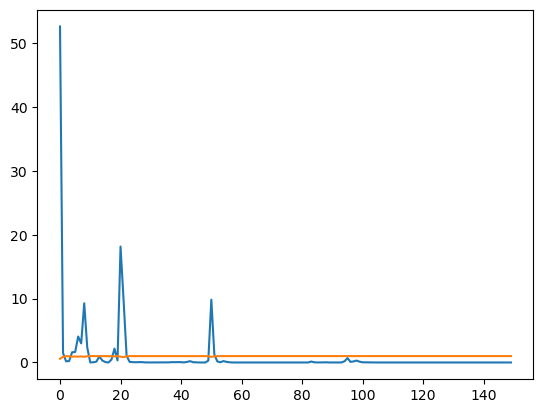

In [40]:
plt.plot(disc_loss)

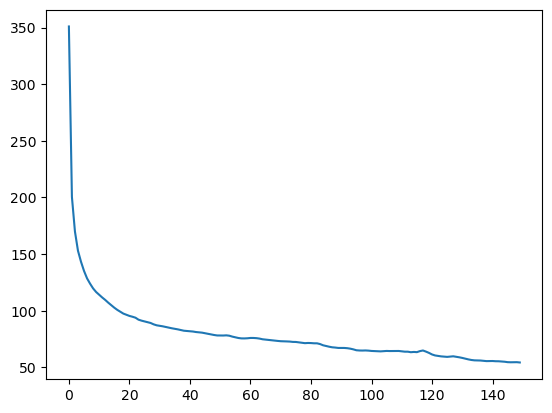

In [41]:
plt.plot(gen_loss)

In [42]:
generator.save_weights("generator_weights.h5")
discriminator.save_weights("discriminator_weights.h5")
gan_model.save_weights("gan_model_weights.h5")


In [43]:
generator.load_weights("generator_weights.h5")
discriminator.load_weights("discriminator_weights.h5")
gan_model.load_weights("gan_model_weights.h5")
